# Used grammars

## G0

```
<e>  ::=  <e>+<e>|
          <e>-<e>|
          <e>*<e>|
		  (<e>) |
          pdiv(<e>,<e>)|
          psqrt(<e>)|
          np.sin(<e>)|
          np.tanh(<e>)|
          np.exp(<e>)|
          plog(<e>)|
          x[:, <col>]|
          <c><c><c>.<c><c><c>
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<col> ::= GE_RANGE:dataset_n_vars
```

## G1

```
<e> ::= (<e> <op> <e>) | <f1>(<e>) | <f2>(<e>, <e>) | <v> | <c>
<op> ::= + | * | -
<f1> ::= psqrt | plog
<f2> ::= pdiv
<v> ::= x[:, <idx>]
<idx> ::= GE_RANGE:dataset_n_vars
<c> ::= -1.0 | -0.1 | -0.01 | -0.001 | 0.001 | 0.01 | 0.1 | 1.0
```

## G2

```
<e>  ::=  <e>+<e>|
          <e>-<e>|
          <e>*<e>|
		  (<e>) |
          pdiv(<e>,<e>)|
          psqrt(<e>)|
          np.sin(<e>)|
          np.tanh(<e>)|
          np.exp(<e>)|
          plog(<e>)|
          x[:, <col>]|
          <c><c><c>.<c><c><c> |
		  ge_sigmoid(<e>) |
		  ge_hyperbolic_tangent(<e>) |
		  ge_relu(<e>) |
		  ge_softplus(<e>)
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<col> ::= GE_RANGE:dataset_n_vars
```

## G3

```
<neural_scaffolding> ::= <n_scaffold> + <neural_scaffolding> | <n_scaffold>
<n_scaffold> ::= <n_scaffold_inner>*<n_scaffold_weight>
<n_scaffold_weight> ::= <const_e>
<n_scaffold_inner> ::= <activation_function>(<neural_scaffolding>) | <activation_function>(<e>)
<activation_function> ::= ge_sigmoid |
		  ge_hyperbolic_tangent |
		  ge_relu |
		  ge_softplus

<const_e>  ::=  <const_e>+<const_e>|
          <const_e>-<const_e>|
          <const_e>*<const_e>|
		  (<const_e>) |
          pdiv(<const_e>,<const_e>)|
          psqrt(<const_e>)|
          np.sin(<const_e>)|
          np.tanh(<const_e>)|
          np.exp(<const_e>)|
          plog(<const_e>)|
          <c><c>.<c><c>

<e>  ::=  <e>+<e>|
          <e>-<e>|
          <e>*<e>|
		  (<e>) |
          pdiv(<e>,<e>)|
          psqrt(<e>)|
          np.sin(<e>)|
          np.tanh(<e>)|
          np.exp(<e>)|
          plog(<e>)|
          x[:, <col>]|
          <c><c>.<c><c>
		  
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<col> ::=  GE_RANGE:dataset_n_vars
```

# PonyGE2 supplementary code

Code below provides functions that are used in the grammars. The code is pasted from original PonyGE2 implementation and supplemented by functions used in neural networks as activation functions

In [1]:
#@title ponyge
from math import ceil

import numpy as np

np.seterr(all="raise")


def return_one_percent(num, pop_size):
    """
    Returns either one percent of the population size or a given number,
    whichever is larger.

    :param num: A given number of individuals (NOT a desired percentage of
    the population).
    :param pop_size: A given population size.
    :return: either one percent of the population size or a given number,
    whichever is larger.
    """

    # Calculate one percent of the given population size.
    percent = int(round(pop_size / 100))

    # Return the biggest number.
    if percent < num:
        return num
    else:
        return percent


def return_percent(num, pop_size):
    """
    Returns [num] percent of the population size.

    :param num: A desired percentage of the population.
    :param pop_size: A given population size.
    :return: [num] percent of the population size.
    """

    return int(round(num * pop_size / 100))


def aq(a, b):
    """aq is the analytic quotient, intended as a "better protected
    division", from: Ji Ni and Russ H. Drieberg and Peter I. Rockett,
    "The Use of an Analytic Quotient Operator in Genetic Programming",
    IEEE Transactions on Evolutionary Computation.

    :param a: np.array numerator
    :param b: np.array denominator
    :return: np.array analytic quotient, analogous to a / b.

    """
    return a / np.sqrt(1.0 + b ** 2.0)


def pdiv(x, y):
    """
    Koza's protected division is:

    if y == 0:
      return 1
    else:
      return x / y

    but we want an eval-able expression. The following is eval-able:

    return 1 if y == 0 else x / y

    but if x and y are Numpy arrays, this creates a new Boolean
    array with value (y == 0). if doesn't work on a Boolean array.

    The equivalent for Numpy is a where statement, as below. However
    this always evaluates x / y before running np.where, so that
    will raise a 'divide' error (in Numpy's terminology), which we
    ignore using a context manager.

    In some instances, Numpy can raise a FloatingPointError. These are
    ignored with 'invalid = ignore'.

    :param x: numerator np.array
    :param y: denominator np.array
    :return: np.array of x / y, or 1 where y is 0.
    """
    try:
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(y == 0, np.ones_like(x), x / y)
    except ZeroDivisionError:
        # In this case we are trying to divide two constants, one of which is 0
        # Return a constant.
        return 1.0


def rlog(x):
    """
    Koza's protected log:
    if x == 0:
      return 1
    else:
      return log(abs(x))

    See pdiv above for explanation of this type of code.

    :param x: argument to log, np.array
    :return: np.array of log(x), or 1 where x is 0.
    """
    with np.errstate(divide='ignore'):
        return np.where(x == 0, np.ones_like(x), np.log(np.abs(x)))


def ppow(x, y):
    """pow(x, y) is undefined in the case where x negative and y
    non-integer. This takes abs(x) to avoid it.

    :param x: np.array, base
    :param y: np.array, exponent
    :return: np.array x**y, but protected

    """
    return np.abs(x) ** y


def ppow2(x, y):
    """pow(x, y) is undefined in the case where x negative and y
    non-integer. This takes abs(x) to avoid it. But it preserves
    sign using sign(x).

    :param x: np.array, base
    :param y: np.array, exponent
    :return: np.array, x**y, but protected
    """
    return np.sign(x) * (np.abs(x) ** y)


def psqrt(x):
    """
    Protected square root operator

    :param x: np.array, argument to sqrt
    :return: np.array, sqrt(x) but protected.
    """
    return np.sqrt(np.abs(x))


def psqrt2(x):
    """
    Protected square root operator that preserves the sign of the original
    argument.

    :param x: np.array, argument to sqrt
    :return: np.array, sqrt(x) but protected, preserving sign.
    """
    return np.sign(x) * (np.sqrt(np.abs(x)))


def plog(x):
    """
    Protected log operator. Protects against the log of 0.

    :param x: np.array, argument to log
    :return: np.array of log(x), but protected
    """
    return np.log(1.0 + np.abs(x))


def ave(x):
    """
    Returns the average value of a list.

    :param x: a given list
    :return: the average of param x
    """

    return np.mean(x)


def percentile(sorted_list, p):
    """
    Returns the element corresponding to the p-th percentile
    in a sorted list

    :param sorted_list: The sorted list
    :param p: The percentile
    :return: The element corresponding to the percentile
    """

    return sorted_list[ceil(len(sorted_list) * p / 100) - 1]


def binary_phen_to_float(phen, n_codon, min_value, max_value):
    """
    This method converts a phenotype, defined by a
    string of bits in a list of float values

    :param phen: Phenotype defined by a bit string
    :param n_codon: Number of codons per gene, defined in the grammar
    :param min_value: Minimum value for a gene
    :param max_value: Maximum value for a gene
    :return: A list os float values, representing the chromosome
    """

    i, count, chromosome = 0, 0, []

    while i < len(phen):
        # Get the current gene from the phenotype string.
        gene = phen[i:(i + n_codon)]

        # Convert the bit string in gene to an float/int
        gene_i = int(gene, 2)
        gene_f = float(gene_i) / (2 ** n_codon - 1)

        # Define the variation for the gene
        delta = max_value[count] - min_value[count]

        # Append the float value to the chromosome list
        chromosome.append(gene_f * delta + min_value[count])

        # Increment the index and count.
        i = i + n_codon
        count += 1

    return chromosome


def ilog(n, base):
    """
    Find the integer log of n with respect to the base.

    >>> import math
    >>> for base in range(2, 16 + 1):
    ...     for n in range(1, 1000):
    ...         assert ilog(n, base) == int(math.log(n, base) + 1e-10), '%s %s' % (n, base)
    """
    count = 0
    while n >= base:
        count += 1
        n //= base
    return count


def sci_notation(n, prec=3):
    """
    Represent n in scientific notation, with the specified precision.

    >>> sci_notation(1234 * 10**1000)
    '1.234e+1003'
    >>> sci_notation(10**1000 // 2, prec=1)
    '5.0e+999'
    """
    base = 10
    exponent = ilog(n, base)
    mantissa = n / base ** exponent
    return '{0:.{1}f}e{2:+d}'.format(mantissa, prec, exponent)


def ge_sigmoid(x):
    return (1/(1+np.exp(x)))

def ge_hyperbolic_tangent(x):
    return (np.exp(x)-np.exp(x*(-1)))/(np.exp(x)+np.exp(x*(-1)))

def ge_relu(x):
    return np.maximum(x, 0)

def ge_softplus(x):
    return np.log(1+np.exp(x))

# Testing on external datasets

## Test on Car Prices DS; success

https://www.kaggle.com/datasets/asinow/car-price-dataset/data

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("car_price_dataset.csv")

In [ ]:
df = pd.get_dummies(df,columns=['Brand','Model','Fuel_Type','Transmission'])
dummies_columns = [col for col in df.columns if col.startswith('Brand') or col.startswith('Model') or col.startswith('Fuel_Type') or col.startswith('Transmission')]
df[dummies_columns] = df[dummies_columns].astype(int)
df['Price'] = df.pop('Price')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [ ]:
dfr = pd.DataFrame()
dfr["real_price"] = df["Price"]
x = df.to_numpy()

### Common solution

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          carprices/train.txt
DATASET_TEST:           carprices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g0.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```

In [ ]:
out =  602.000*psqrt((psqrt(x[:, 3])-680.694-np.sin(886.119)+np.tanh(pdiv(np.sin(x[:, 19]),x[:, 4]))+psqrt((psqrt(x[:, 51])-psqrt(plog(x[:, 51]))*np.tanh(x[:, 18])-plog((x[:, 19]))))*psqrt(986.427)))*plog(plog(x[:, 2]))+psqrt(pdiv(psqrt(x[:, 3])-680.046,x[:, 4]+psqrt((psqrt((plog(psqrt(x[:, 51]))-pdiv(np.sin(x[:, 51])-plog(plog(x[:, 51]))+np.tanh(x[:, 18])-plog((x[:, 29])),psqrt(986.427))+plog(np.sin(x[:, 20]))+plog(np.sin(plog(plog(956.952)))+x[:, 45])+np.tanh(np.exp(x[:, 50])*plog(509.943))))-pdiv((pdiv(np.tanh(738.547),np.sin((np.tanh(np.tanh(855.154))))))-np.sin(680.046),x[:, 4]+psqrt((psqrt(x[:, 51])-plog(plog(x[:, 51]))+np.tanh(x[:, 18])-plog((x[:, 29])))))-psqrt(986.427)))))*plog(plog(x[:, 2]))+psqrt(pdiv(np.tanh(x[:, 47]),plog(plog(x[:, 51]))+np.tanh(np.sin(psqrt(plog(x[:, 41]))+pdiv(np.exp(x[:, 40]),(psqrt(x[:, 50])*plog(306.968)))*np.sin(600.401)*plog(np.sin(591.728))-plog(349.665*plog(np.sin(091.000)))*x[:, 49]))))*psqrt((psqrt(x[:, 3])*786.580-plog((pdiv(x[:, 10],plog(np.sin(x[:, 23]))*psqrt(x[:, 48]))))*np.tanh(plog(psqrt(252.050)*(np.tanh(np.sin(plog(np.exp(x[:, 51]))+np.tanh(x[:, 42])*plog((x[:, 50])))))))))-psqrt(996.427)
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

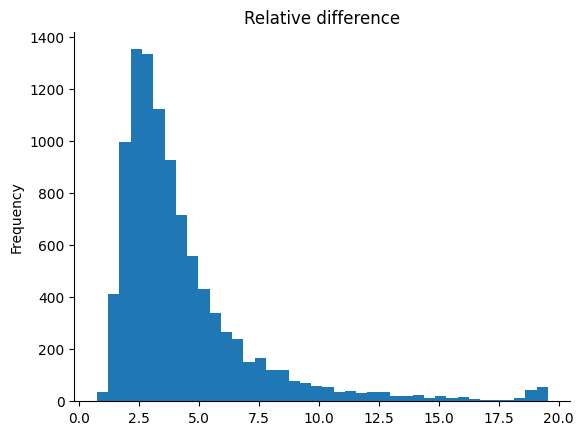

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

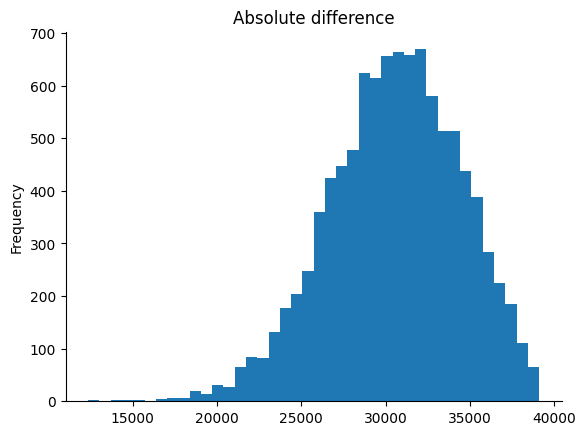

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Solution with neural-like grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          carprices/train.txt
DATASET_TEST:           carprices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

#### Attempt 1

In [ ]:
out =  ge_softplus(91.37)*90.19-00.97 + ge_relu(pdiv(pdiv(44.01,x[:, 50]),np.exp(psqrt(np.sin((plog(np.exp(psqrt(pdiv(np.tanh(psqrt(np.exp(54.55))),02.00)+pdiv(46.16*(x[:, 50]),82.21)*np.tanh(np.sin(psqrt(19.73)))+psqrt(plog(68.97))*05.82+pdiv(46.30,34.83)-np.tanh(70.82)+pdiv(11.96,03.82)-pdiv(41.10,x[:, 50]-np.exp(psqrt(x[:, 47]))))))))))))*65.49
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

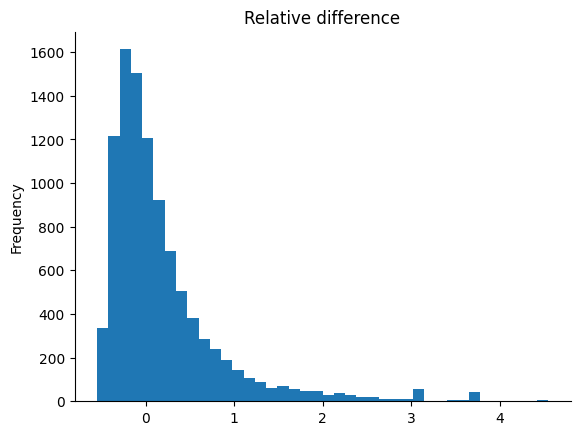

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

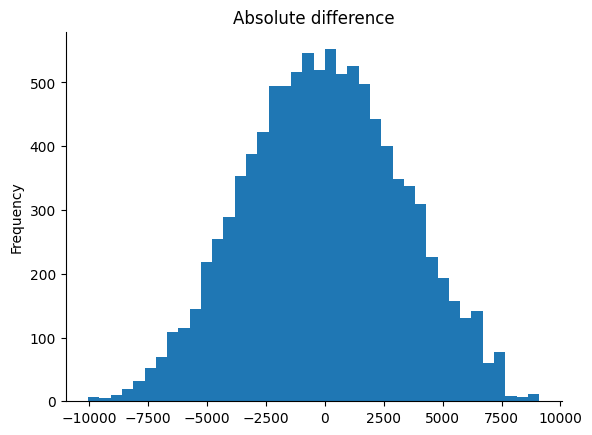

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 2

In [ ]:
out =  ge_softplus((np.exp((plog(plog(plog(psqrt(psqrt(np.sin(12.46))))))))*60.28*psqrt(plog(x[:, 1]))))*40.79 + ge_softplus(np.exp(np.sin(psqrt((psqrt((np.exp(03.84)))))))*(np.tanh(np.tanh((np.sin(pdiv(68.03,np.sin(63.88))*np.exp((psqrt(plog(x[:, 0]))))))*pdiv(plog(30.11*np.sin(03.17)),np.sin(x[:, 48])))))*(plog((np.tanh(np.tanh(x[:, 29])))*plog(np.tanh(05.68))+np.exp(89.95)-plog(plog(x[:, 49]))*x[:, 0])))*48.64 + ge_relu(x[:, 1]-29.63*(np.sin(np.sin(psqrt((psqrt((psqrt(43.14)))))))*np.sin(((plog(66.01+np.sin(05.52)*90.15))*np.sin(plog(x[:, 2]*psqrt(psqrt(25.43))-x[:, 1]))))*plog(plog(94.63))-psqrt(plog(x[:, 1])))-np.sin(plog((59.40)+plog(psqrt(35.65))*plog(02.16)*(np.sin(psqrt(np.sin((plog(x[:, 46]))))))*psqrt(x[:, 1]))))*49.12 + ge_relu(97.12*(np.tanh(plog(np.sin(psqrt(26.80))*np.sin(x[:, 46]))))+(np.exp(np.exp(x[:, 49])+plog((np.exp(plog(psqrt((87.35))-pdiv(x[:, 47],x[:, 51])))))*np.sin(plog(plog(np.tanh(np.tanh(85.58)-x[:, 41]*psqrt(12.66)))-plog(x[:, 1]))))))*30.14
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

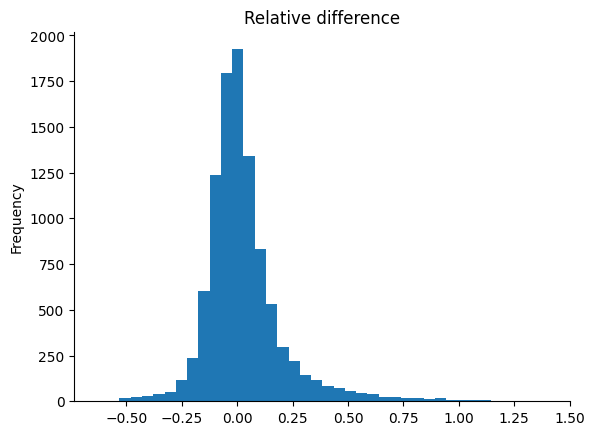

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

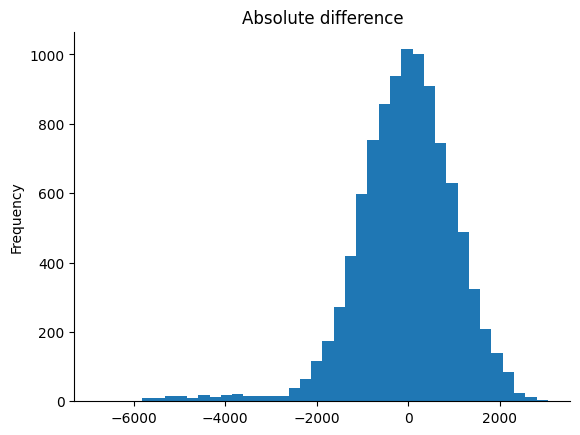

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Test on Heart DS

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("heart.csv")

In [ ]:
df = pd.get_dummies(df,columns=['Sex', 'ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], dtype=int)
df['HeartDisease'] = df.pop('HeartDisease')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [ ]:
x = df.to_numpy()

### Common techniques

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.70
DATASET_TRAIN:          heart/train.txt
DATASET_TEST:           heart/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [ ]:
out = pdiv(pdiv(x[:, 18], psqrt(((psqrt(psqrt(((0.01 - plog(-1.0)) + (x[:, 9] + x[:, 4])))) * (((0.01 + x[:, 6]) - -0.01) * x[:, 15])) * plog(x[:, 2])))), pdiv(0.1, ((pdiv((pdiv(x[:, 15], pdiv(pdiv(x[:, 6], pdiv(0.1, (x[:, 11] * plog(x[:, 10])))), pdiv(x[:, 18], x[:, 15]))) * plog(x[:, 2])), pdiv(0.1, (x[:, 7] - (pdiv(0.1, x[:, 8]) * (plog(psqrt((1.0 + x[:, 13]))) + plog(pdiv(x[:, 19], plog(x[:, 2])))))))) + psqrt(x[:, 3])) - pdiv(-1.0, x[:, 18]))))

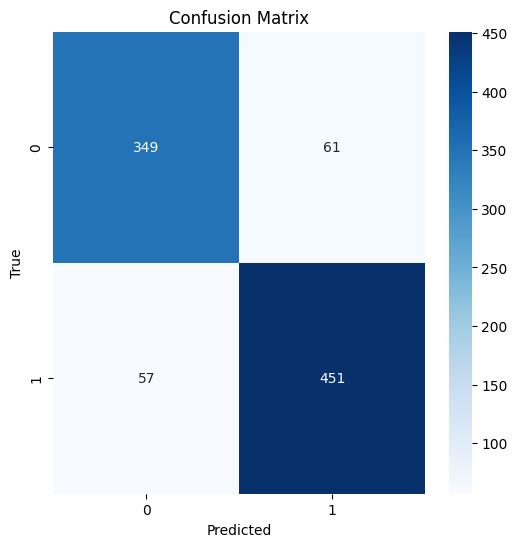

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       410
           1       0.88      0.89      0.88       508

    accuracy                           0.87       918
   macro avg       0.87      0.87      0.87       918
weighted avg       0.87      0.87      0.87       918



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Solution with neural-like grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.70
DATASET_TRAIN:          heart/train.txt
DATASET_TEST:           heart/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [ ]:
out = ge_relu(x[:, 16]+(pdiv(psqrt(x[:, 15]-np.tanh(pdiv(x[:, 2],psqrt(x[:, 9])+pdiv(x[:, 6],np.sin(x[:, 18]))))),np.tanh(plog(np.exp(x[:, 17])-np.exp(x[:, 5])-x[:, 8]))+np.sin(x[:, 18])*(x[:, 14])+x[:, 18]-psqrt(plog((plog(np.sin(np.tanh(np.exp(x[:, 11])))+np.sin(x[:, 10])*03.89-psqrt(x[:, 5])*x[:, 8])))))))*93.10

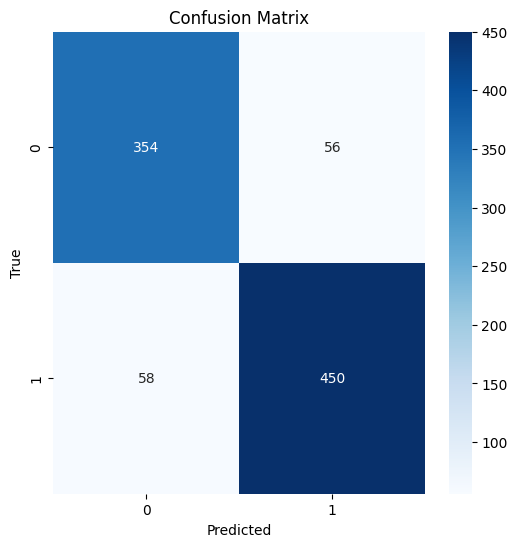

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       410
           1       0.89      0.89      0.89       508

    accuracy                           0.88       918
   macro avg       0.87      0.87      0.87       918
weighted avg       0.88      0.88      0.88       918



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

In [ ]:
out =  ge_relu((pdiv(x[:, 18],x[:, 0]))*pdiv(x[:, 7],x[:, 2])+x[:, 3]*psqrt(np.sin(pdiv(x[:, 18],x[:, 2])))-x[:, 16]*np.tanh(plog(x[:, 11]))+(pdiv(x[:, 18],x[:, 0]))*pdiv(x[:, 7],x[:, 2])+x[:, 3]*plog(psqrt(np.sin(np.tanh(x[:, 18]))))+x[:, 2]*x[:, 16]*np.tanh(np.tanh(plog(x[:, 13])))*(pdiv(x[:, 18],x[:, 2]))*plog(08.80+np.exp(plog(psqrt(x[:, 17]))+x[:, 2]))+x[:, 16]*plog(psqrt(np.sin(pdiv(x[:, 11],x[:, 2]))))+x[:, 16]*np.tanh(plog(x[:, 8]))*psqrt(plog(x[:, 2]*pdiv(x[:, 7],pdiv(x[:, 18],x[:, 16]))+plog(74.28)+x[:, 2]*x[:, 16]*np.tanh(plog(x[:, 8])))*psqrt(plog(np.tanh(x[:, 5]))*plog(np.tanh(pdiv(x[:, 18],x[:, 2])+x[:, 16]*np.tanh(plog(x[:, 7])))))))*pdiv(psqrt((psqrt(psqrt(24.28)-(80.69))))*plog((np.exp(pdiv(np.exp(psqrt(np.sin(np.exp(82.71))))*59.32,(psqrt(np.sin((42.80)))))-plog(plog(np.sin(np.sin((80.69)))))))),plog((np.exp(psqrt(pdiv(np.sin(np.exp((80.69*plog((18.71))))),np.sin(psqrt(np.sin(28.92)))))))))

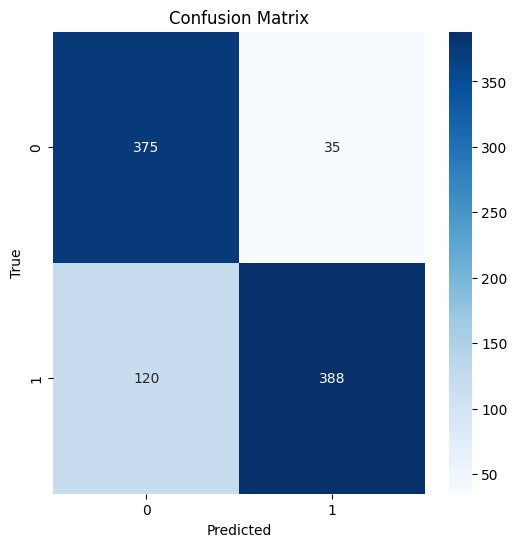

              precision    recall  f1-score   support

           0       0.76      0.91      0.83       410
           1       0.92      0.76      0.83       508

    accuracy                           0.83       918
   macro avg       0.84      0.84      0.83       918
weighted avg       0.85      0.83      0.83       918



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

## Test on Housing prices

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("Housing.csv")

In [ ]:
df = pd.get_dummies(df, columns=['furnishingstatus'])
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})
dummies_columns = [col for col in df.columns if col.startswith('furnishingstatus')]
df[dummies_columns] = df[dummies_columns].astype(int)
df['price'] = df.pop('price')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [ ]:
dfr = pd.DataFrame()
dfr["real_price"] = df["price"]
x = df.to_numpy()

### Common methods

#### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g0.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [ ]:
out = x[:, 0]*410.107+np.sin((np.tanh(351.666)))+837.652*x[:, 3]*715.606+np.sin(psqrt(x[:, 9]))+psqrt(x[:, 2])*psqrt(655.574)*psqrt(x[:, 0])*780.728+343.603-pdiv((089.434)+plog(710.752+921.888)+psqrt(x[:, 0]),pdiv(x[:, 0],plog(plog(x[:, 8]))))*x[:, 0]+350.853*x[:, 1]*psqrt(142.295*x[:, 6]-x[:, 9])*074.544+np.tanh(221.214)*pdiv(069.394,plog(np.exp(np.tanh(710.742+824.834))))+(x[:, 10]-x[:, 5])*x[:, 12]*838.229*803.247-(psqrt(x[:, 0]))*427.034+((psqrt(np.tanh(703.439)*(294.935)+651.642*np.sin(072.924)))+np.tanh(741.010))*plog(np.sin((np.tanh(321.666)))+837.652*x[:, 3]*715.606+np.sin(psqrt(x[:, 9]))+psqrt(x[:, 2])*psqrt(np.tanh(x[:, 6]))*361.580+x[:, 4]-(069.632)+np.tanh(plog(812.047))+(np.tanh(np.sin(pdiv(843.141,np.sin(342.074*((psqrt(np.tanh(703.339)*(236.435)+681.642*np.sin(343.374)))))))))*584.536)
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

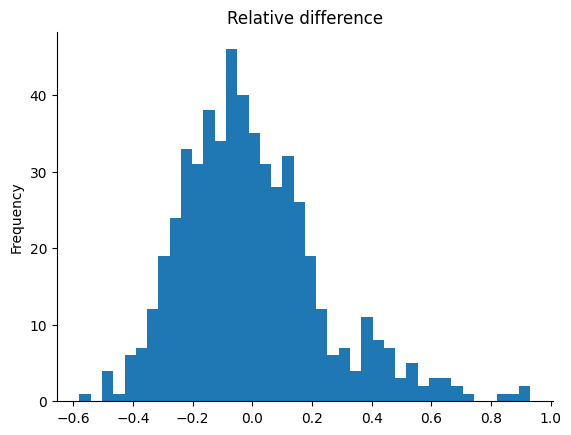

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

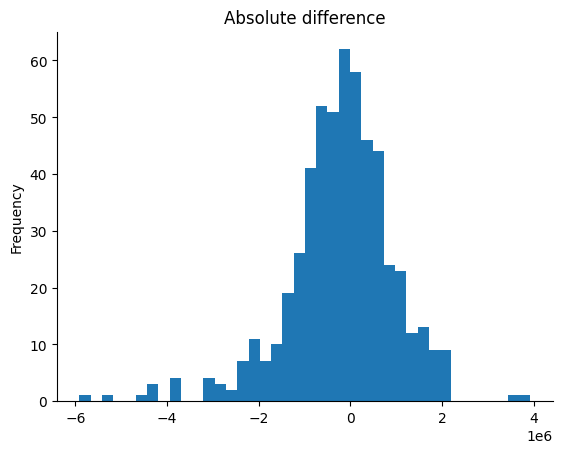

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 2

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1200
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g0.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1100
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [ ]:
out = psqrt(np.exp(psqrt(941.351-(pdiv(np.sin(x[:, 1])-np.sin(238.626-pdiv(pdiv(psqrt(np.exp(337.447)*np.sin(psqrt(psqrt(psqrt(np.exp(x[:, 6]+plog(x[:, 2]))))+x[:, 4]*028.073)))+127.931,np.sin(427.607)),165.067)-psqrt(pdiv((psqrt(x[:, 9]))+np.exp(pdiv(172.357-pdiv((np.sin(np.sin(plog(psqrt(178.887)))-plog(psqrt(763.296))*np.exp((697.435)))),plog(x[:, 7]))*091.566,np.tanh(469.724))),pdiv(172.357-(np.sin(np.sin(np.tanh(psqrt(138.636)))-475.102))-((np.tanh((np.sin(np.sin(plog(psqrt(178.636)))-719.733))-np.sin(np.exp((699.808))*plog(x[:, 7])-091.563)*np.sin(599.205))))*np.sin(x[:, 7]),np.sin(847.741))))),pdiv(psqrt(np.sin(np.tanh(152.319))-(psqrt(np.sin((psqrt(950.991)))))-np.sin(499.447)),pdiv(psqrt((np.sin(x[:, 3])-(301.300)-pdiv(x[:, 8],np.tanh(023.331))))+np.tanh((x[:, 11]+x[:, 13]))*np.exp(np.tanh(np.exp(plog(plog(253.130)))*pdiv(x[:, 8],(x[:, 8]+x[:, 13]))+psqrt((np.tanh((x[:, 6]+x[:, 13]))-np.exp(np.tanh(psqrt(plog(plog(433.583)))*np.tanh(299.808))))))),x[:, 1]+pdiv(x[:, 1],x[:, 9]-pdiv(013.901*np.sin(913.868),pdiv(x[:, 11],np.sin(psqrt(np.sin(x[:, 5])*psqrt(pdiv(974.989,psqrt(913.166))))))*x[:, 8]))*x[:, 11])))))))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

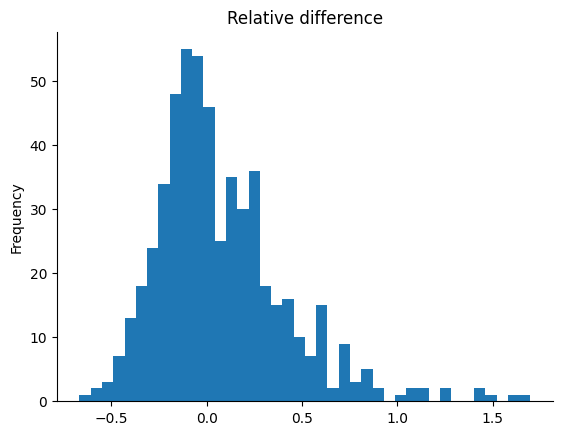

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

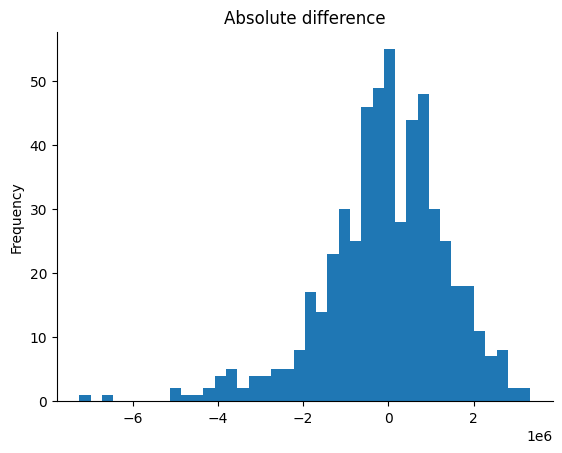

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 3

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1500
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g0.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         15
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1200
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [ ]:
out = 806.488*psqrt(np.exp(plog(x[:, 0])))*(x[:, 1]*x[:, 2]+x[:, 6]+(x[:, 3]*x[:, 3]+070.000-np.tanh(548.205))+x[:, 8]*np.exp(x[:, 2]-np.sin(923.000))+x[:, 10]*np.exp(x[:, 2]-np.sin(x[:, 3]*024.403)))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

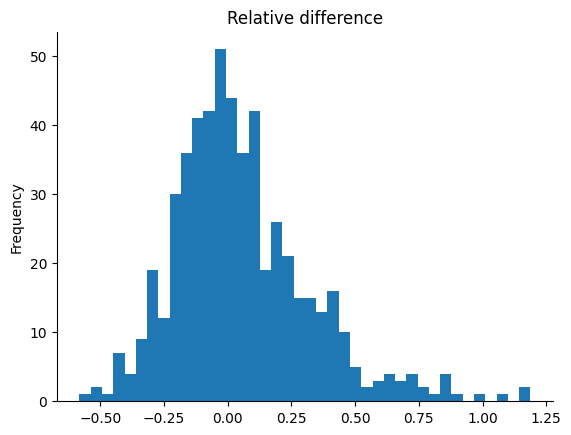

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

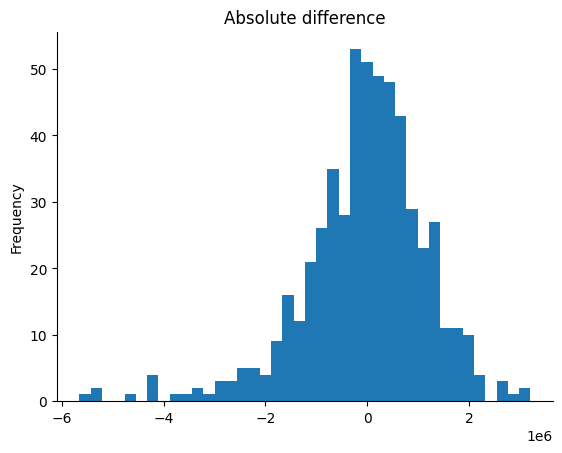

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Neural-like approach

#### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```


In [ ]:
out = ge_relu(ge_relu(x[:, 0])*50.20)*np.exp(np.exp(np.tanh((plog(pdiv(73.05,59.97))))))+(33.71*psqrt(16.89)*65.38*np.exp(psqrt(30.79))+30.56)+np.exp(np.tanh(np.exp(np.tanh(73.98-np.exp(plog(np.tanh(np.exp(np.tanh(96.69-35.17))))))))) + ge_relu(ge_relu((x[:, 8]))*np.exp(np.exp(np.tanh(27.89*50.62))))*43.30*(psqrt(plog(14.01)*69.73*np.exp(psqrt(32.96))+psqrt((np.exp(30.59)))))+np.sin(33.67)*plog(np.tanh(85.17-psqrt(15.90))*74.54-np.sin(psqrt(np.exp(np.exp(np.exp(np.tanh((np.tanh(np.tanh(psqrt(96.24))))))))))+psqrt(00.73))+pdiv(np.exp(np.exp(np.tanh(pdiv(96.55,59.97))))+(33.84*psqrt(plog(psqrt(86.24)))*psqrt(07.63))+pdiv(np.exp(np.exp(np.tanh(pdiv(77.59,59.97))))+(31.71*(13.96)-74.34*np.exp(psqrt(48.99))+60.56)+np.exp(np.tanh((np.tanh(np.tanh(13.89)-75.34*np.exp(psqrt(30.99))+60.05)))),np.exp(np.exp(np.tanh(np.exp(np.tanh(psqrt(36.86)-plog(psqrt(np.exp(np.tanh(np.sin(89.09))))))))))),85.17) + ge_relu(np.exp((psqrt((x[:, 2])))*np.exp(x[:, 4])))*87.89*99.62
out = ge_relu(psqrt(plog(np.sin(58.42*77.17-x[:, 2]-psqrt(72.00)-x[:, 6]*x[:, 9])*x[:, 0]*x[:, 3])))*(48.27)*99.87*pdiv(plog(np.exp(plog(64.15)))+18.94,pdiv(47.89,58.89*19.26))-08.25-(pdiv(pdiv(psqrt(plog(85.74))-np.sin(np.exp(42.89)),65.80),np.exp(82.85)))-(35.77)*99.77*pdiv(plog(np.exp(plog(84.55)))+19.98,pdiv(45.09,58.94*19.88))-np.exp(np.exp(49.95*pdiv(47.89,54.54*19.37)))-14.32+(pdiv(pdiv(plog(39.15)*89.96,49.96-pdiv(47.89,16.75*plog(np.exp(plog(44.63)))*np.sin(85.11))),39.78*psqrt(14.67+57.12)))-pdiv(98.64,np.exp(plog(((pdiv(49.79,np.sin(np.tanh(np.sin(82.91))))))+pdiv(plog(psqrt(18.73+57.10)-np.tanh(99.64)-plog(plog(plog((09.28))))+psqrt(pdiv(pdiv(38.82,(psqrt(20.69))),22.76))),plog(pdiv(np.tanh(27.73),39.92+32.03)))*15.13))+np.sin(pdiv((plog(pdiv(89.46,np.sin(31.88+np.sin(51.77))))),(np.tanh(85.48))))) + ge_softplus(85.11*plog(psqrt(x[:, 10])))*97.84 + ge_hyperbolic_tangent(np.sin(26.68))*plog(np.sin(np.sin(np.tanh(np.tanh(83.51)-80.60))-59.29)) + ge_relu(ge_hyperbolic_tangent(np.sin(x[:, 8]))*79.56)*pdiv(93.50,np.sin(09.42))-np.exp(psqrt(pdiv(np.exp(plog(pdiv(plog(plog(89.46))-np.tanh(97.25),90.82))),np.tanh((plog(pdiv(39.89,97.63)))-58.57-89.02*np.tanh(58.38)))))
out = ge_relu(ge_relu(psqrt(x[:, 0]))*np.exp(psqrt(83.00)))*plog(np.exp((psqrt(40.00)))-99.59) + ge_relu(ge_hyperbolic_tangent(x[:, 7])*np.exp(psqrt(97.40)) + ge_hyperbolic_tangent(x[:, 6])*np.exp(psqrt(92.31)) + ge_relu(ge_relu(x[:, 8])*np.exp(psqrt(81.34)) + ge_relu(x[:, 3])*98.92 + ge_relu(psqrt(x[:, 10]))*np.exp((psqrt(69.66)))+np.sin(np.exp(20.24*13.98)))*plog(np.tanh(np.sin(24.17))-25.74))*38.69

dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

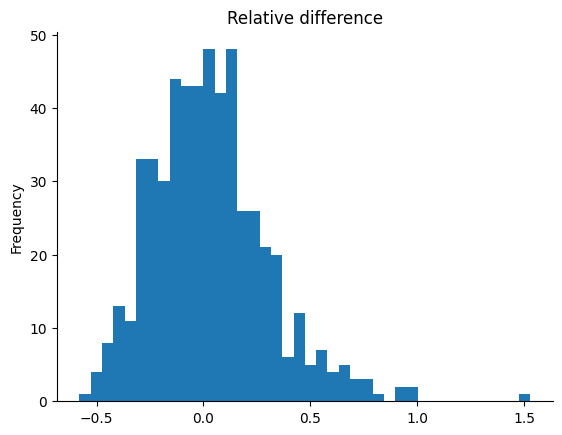

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

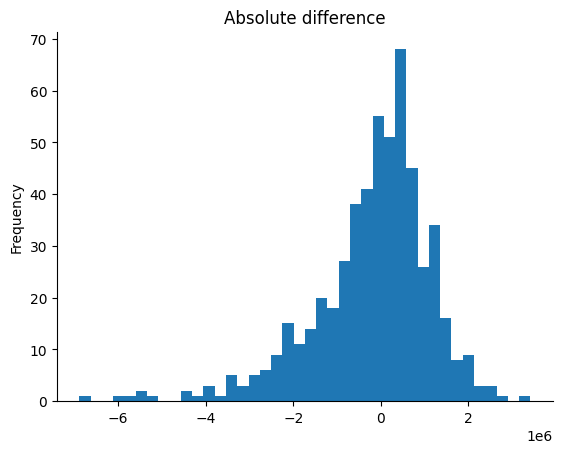

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 2

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```


In [ ]:
out = ge_relu(x[:, 0])*np.exp(plog(56.18*psqrt(psqrt(((58.87*34.59-np.sin(67.41)*12.15*35.06+20.27*86.80)-72.08)))))-psqrt(np.sin(49.43)+pdiv(34.82,plog((75.89-48.61)-pdiv(np.exp(plog(pdiv(58.14,psqrt(np.sin(27.21)))))+78.77,pdiv(pdiv((np.exp(15.20)),np.tanh(psqrt(14.54)+67.78)*np.sin(55.78*81.89-22.96)),60.82)))))-np.sin(psqrt(np.exp(81.09)+50.14*psqrt(psqrt(((64.65*np.exp(plog(56.68*psqrt(psqrt((np.sin(27.48)-86.19)))))-54.17-88.69)+26.96)))))*63.48-np.sin(psqrt(np.sin(04.09)+50.12*psqrt(psqrt(((65.21*88.12-45.46)+33.76)))))*np.sin(79.48)*np.exp(15.28) + ge_relu(x[:, 3])*plog(np.exp(psqrt(88.12)*45.89)) + ge_hyperbolic_tangent(38.77)*np.sin(psqrt(np.exp(15.28))) + ge_relu(x[:, 8])*((59.19*66.26-(pdiv((69.45),12.18*06.01)))-17.15) + ge_sigmoid(x[:, 3])*77.41*np.sin((plog(58.86)))*72.68*12.98*89.44-psqrt(14.66)
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

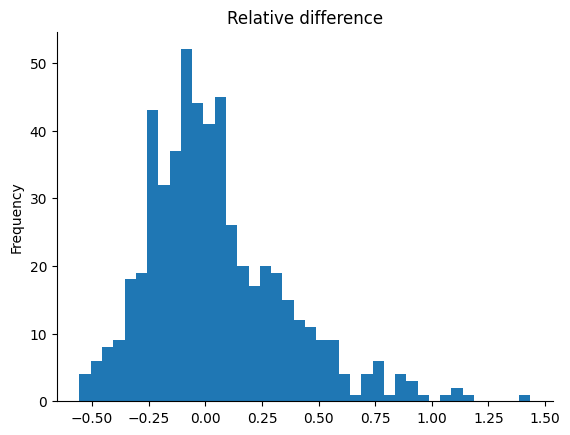

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

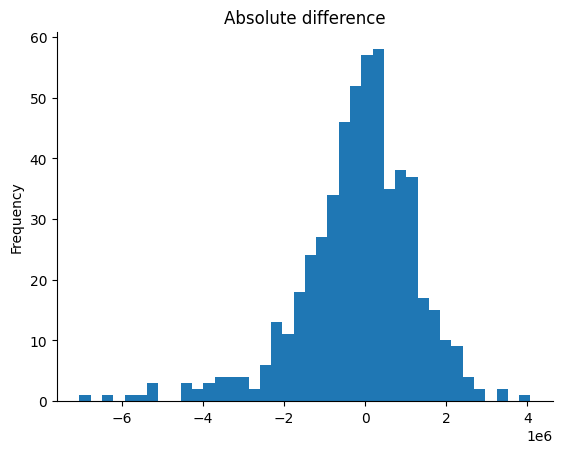

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 3

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```



In [ ]:
out = ge_relu(72.21)*23.11*80.53*25.01+plog(plog(27.36*np.exp(57.33)+28.32+plog(np.sin(33.75)*15.81)*74.38)-np.tanh(26.82-27.13*22.88*psqrt(59.24*psqrt(80.77*psqrt(17.80)))-71.08*np.tanh(87.80*plog((15.12))-13.82-87.17+26.97)-30.52))+psqrt(psqrt(plog(plog(20.11))*np.exp(plog(29.70)))) + ge_relu(ge_relu(x[:, 9])*64.19)*(88.46)*(92.19) + ge_softplus(ge_relu(np.sin(psqrt((plog((x[:, 6]*np.tanh(92.31))))))+(x[:, 4]*78.83)*pdiv(pdiv(np.exp(x[:, 4]),(pdiv((12.27),x[:, 2]))),plog(x[:, 13])+50.41))*84.79)*(57.76)*(99.19) + ge_softplus(ge_relu(np.sin(psqrt(plog(plog((x[:, 5]*np.tanh(62.38))))))+(x[:, 4]*np.tanh(np.exp((x[:, 5]))))*pdiv(pdiv(np.exp(x[:, 4]),plog((plog(np.tanh(x[:, 8]))))),np.tanh((17.07))))*92.16*np.tanh(pdiv(np.exp(48.26),(19.50+11.13)*26.31)))*87.30*plog(86.26*psqrt(psqrt((np.tanh(93.91))*np.exp(92.64+77.62))))#tree 30 generations 600
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

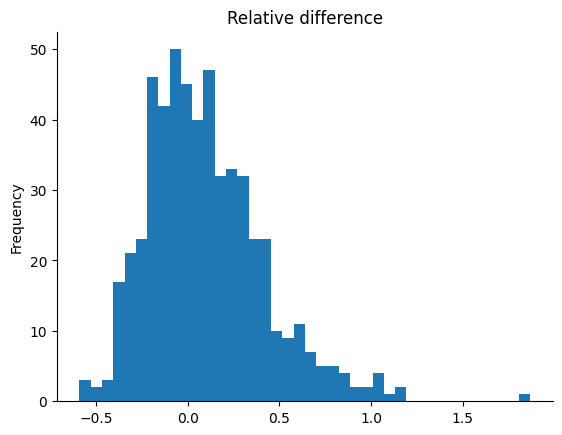

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

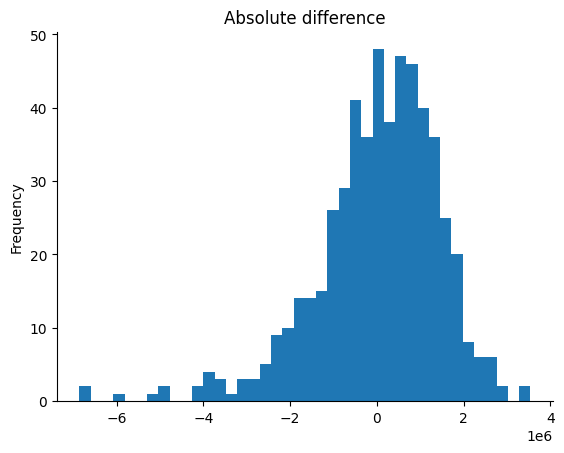

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 4

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            900
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```

In [ ]:
out = ge_relu(plog(x[:, 2]))*np.exp((plog(26.02)+11.00+np.tanh(np.tanh(plog(np.tanh(01.15)))))) + ge_relu(x[:, 0])*72.21*(plog(np.exp(plog(21.79))))+95.51*plog(np.sin(30.42))+55.97*np.tanh(plog(plog(plog(28.97))))+79.58 + ge_softplus(psqrt(x[:, 8])*np.exp(x[:, 2]))*65.50*((plog(np.exp((psqrt(np.exp(plog(66.97)))))))*71.53) + ge_relu((x[:, 3])*psqrt(x[:, 6])*np.exp(x[:, 9]))*(np.exp(psqrt(np.exp(plog(39.97))))*99.99) + ge_relu(psqrt(x[:, 4])*np.exp(x[:, 3]))*68.39*((plog(np.exp(plog(99.98))))*77.97) + ge_relu(psqrt(x[:, 9])+np.exp(x[:, 3]))*plog(np.sin(21.58)) + ge_relu(psqrt(x[:, 4])*np.exp(x[:, 2]))*80.59*((plog(np.exp(plog(89.95))))*72.97) + ge_relu(np.sin(x[:, 9])+np.exp(x[:, 8]))*60.09*(90.01*70.19) + ge_relu(ge_relu(plog(np.sin(plog(np.tanh(x[:, 10])))))*(69.66+np.exp(psqrt((pdiv(03.29,16.59))))+69.28))*psqrt(pdiv(np.exp(14.09),np.tanh(pdiv(np.tanh(np.tanh(12.26)),psqrt(99.65*76.86+95.98))))-72.57)
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

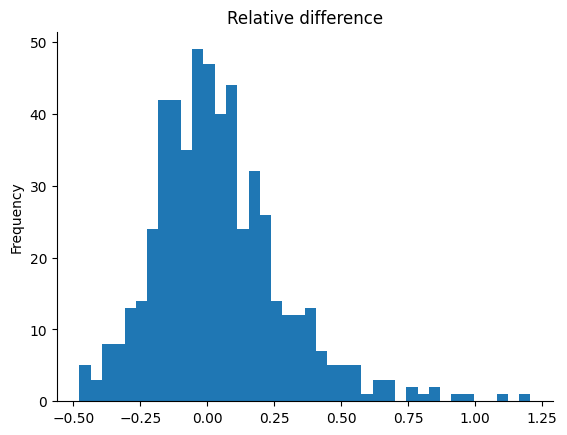

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

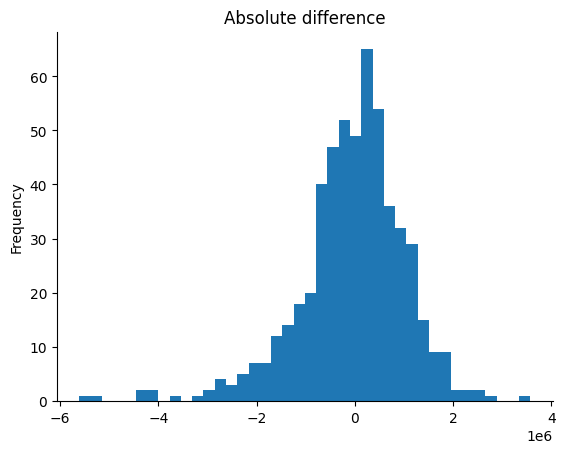

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 5

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1200
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1100
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False


```

In [ ]:
out =  ge_relu(x[:, 0])*50.00*08.00+61.24*psqrt(82.32)*42.00*60.18+plog((psqrt(psqrt(75.20)-np.sin(43.98*64.42))+80.74-plog(np.tanh(np.exp(np.sin(92.05))+((np.tanh(pdiv(np.tanh(88.63)*psqrt(41.23)+79.58*60.26,34.44-np.sin(np.sin(79.18*41.52)*np.tanh(plog(44.48)))))))+05.33))))*plog(pdiv(np.sin(78.54),05.76)-pdiv(pdiv(np.tanh(plog(34.92)),98.32),np.exp((np.tanh(np.sin(86.17)))))) + ge_relu(np.exp(x[:, 2]))*64.89*72.35*34.03+np.sin(np.sin(np.sin(34.23+50.00+29.14+93.60)))+(44.47)-(77.47-np.tanh((51.19)*08.98+np.tanh(61.66)+plog(66.31)-np.exp(psqrt(np.sin((np.tanh(np.sin(psqrt(10.73))))))))+56.74*38.88+psqrt(99.81+(np.tanh((plog(np.tanh(psqrt(97.09)*np.sin(54.39)+np.tanh(59.07+54.54)))))))*94.94)*(46.87)-(pdiv(48.07-np.tanh((51.10)*08.48+pdiv(np.tanh(61.66),plog(06.91))-psqrt(psqrt(np.sin((np.tanh(np.sin(psqrt(31.73))))))))+99.64*98.61+psqrt(39.81+(np.exp((plog(np.tanh(psqrt(97.95)-plog(43.65)+59.95+54.49)))))),np.tanh(pdiv(54.75,49.07)))) + ge_relu(x[:, 3])*np.exp((08.98+np.tanh(61.66)+plog(99.75)-np.exp(psqrt(np.sin(plog(np.tanh(np.sin(plog(30.00)))))))))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

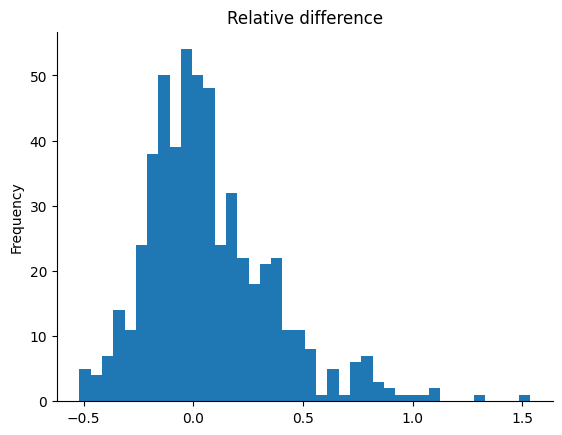

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

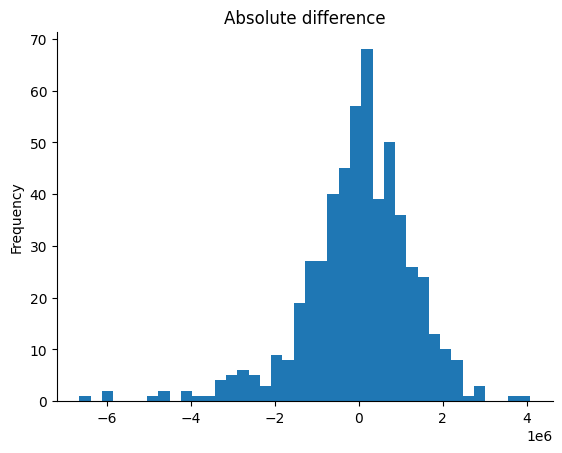

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 6


```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1200
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1100
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False


```

In [ ]:
out =  ge_relu(x[:, 0])*50.00*08.00+61.24*psqrt(82.32)*42.00*60.18+plog((psqrt(psqrt(75.20)-np.sin(43.98*64.42))+80.74-plog(np.tanh(np.exp(np.sin(92.05))+((np.tanh(pdiv(np.tanh(88.63)*psqrt(41.23)+79.58*60.26,34.44-np.sin(np.sin(79.18*41.52)*np.tanh(plog(44.48)))))))+05.33))))*plog(pdiv(np.sin(78.54),05.76)-pdiv(pdiv(np.tanh(plog(34.92)),98.32),np.exp((np.tanh(np.sin(86.17)))))) + ge_relu(np.exp(x[:, 2]))*64.89*72.35*34.03+np.sin(np.sin(np.sin(34.23+50.00+29.14+93.60)))+(44.47)-(77.47-np.tanh((51.19)*08.98+np.tanh(61.66)+plog(66.31)-np.exp(psqrt(np.sin((np.tanh(np.sin(psqrt(10.73))))))))+56.74*38.88+psqrt(99.81+(np.tanh((plog(np.tanh(psqrt(97.09)*np.sin(54.39)+np.tanh(59.07+54.54)))))))*94.94)*(46.87)-(pdiv(48.07-np.tanh((51.10)*08.48+pdiv(np.tanh(61.66),plog(06.91))-psqrt(psqrt(np.sin((np.tanh(np.sin(psqrt(31.73))))))))+99.64*98.61+psqrt(39.81+(np.exp((plog(np.tanh(psqrt(97.95)-plog(43.65)+59.95+54.49)))))),np.tanh(pdiv(54.75,49.07)))) + ge_relu(x[:, 3])*np.exp((08.98+np.tanh(61.66)+plog(99.75)-np.exp(psqrt(np.sin(plog(np.tanh(np.sin(plog(30.00)))))))))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

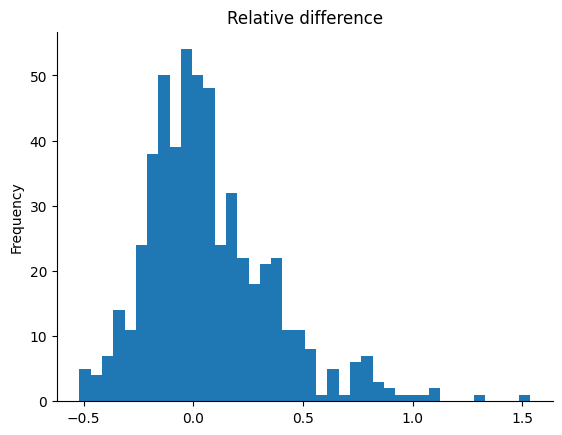

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

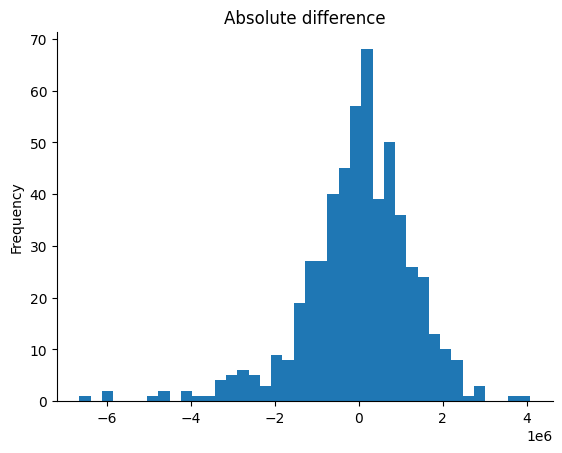

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 7


```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1500
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1100
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False


```

In [ ]:
out =  ge_relu(pdiv(np.tanh(plog((plog((plog(np.exp((psqrt(x[:, 8]))))))))),87.72))*np.exp(20.01) + ge_relu(pdiv(x[:, 1]+x[:, 6],psqrt(np.exp(np.sin(40.72))))*x[:, 0]-np.exp((x[:, 1])))*71.93 + ge_softplus(30.02*np.exp(np.sin(04.75))*(plog(x[:, 3]))*((x[:, 2]))*np.tanh(x[:, 4])+np.sin(np.exp(08.64))+np.sin(plog(99.85))+(np.exp(psqrt(x[:, 2]))*(((x[:, 9]))+np.exp(x[:, 10])))+np.sin(psqrt(22.34)))*psqrt(np.exp(22.59))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

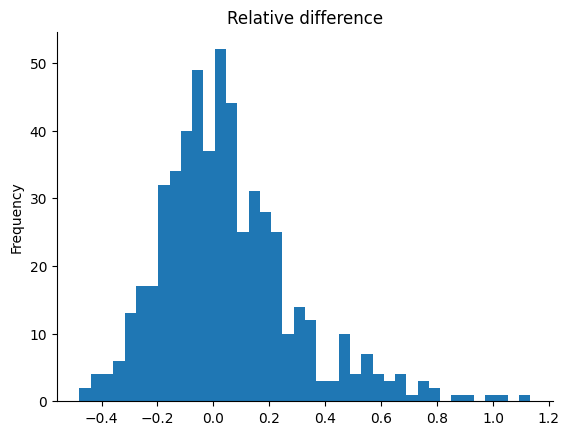

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

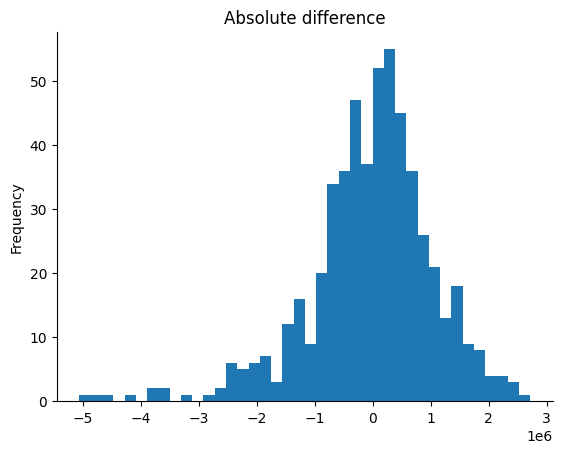

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 8


```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1500
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         18
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1200
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```

In [ ]:
out =  ge_relu(psqrt(np.exp(22.10)))*np.exp(plog(41.18)) + ge_relu((np.exp(psqrt(x[:, 13]-np.exp(psqrt(x[:, 2]-x[:, 13])))))*x[:, 0]+psqrt(x[:, 3]+x[:, 6])*pdiv((x[:, 3]-x[:, 12]),np.tanh((02.20)))*np.sin(psqrt((pdiv(x[:, 7],x[:, 11]))))*x[:, 0]+np.exp(psqrt(pdiv(x[:, 1],np.exp(x[:, 8]-x[:, 6]))))*plog(x[:, 9]-np.tanh(x[:, 2]-x[:, 3]))*np.tanh(x[:, 1]-psqrt(x[:, 9]-x[:, 12]))*plog(x[:, 2]-x[:, 12])*80.76*pdiv(psqrt(x[:, 0]),np.tanh(np.tanh(x[:, 8]))))*(93.01-(44.78)+np.sin(92.22+np.sin((40.47))-32.15*44.14-psqrt(90.71*(13.30))*psqrt(plog(np.tanh(05.31)))-84.00)) + ge_relu(np.exp(np.exp(x[:, 10])))*((99.99))*np.exp(psqrt(38.99))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

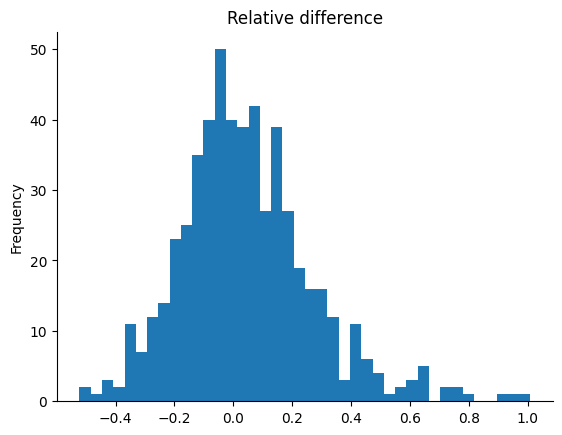

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

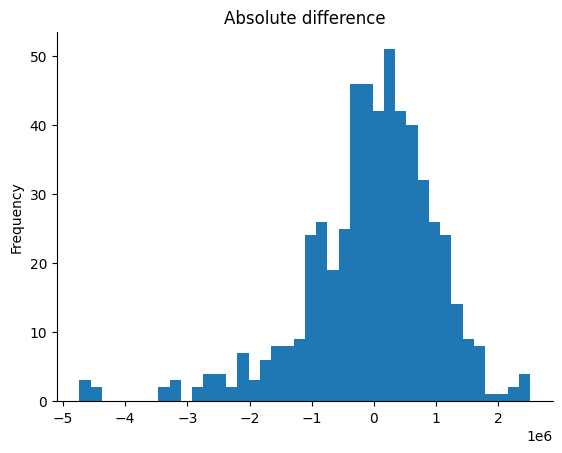

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Attempt 9


```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          hausing_prices/train.txt
DATASET_TEST:           hausing_prices/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1500
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         15
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1200
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [ ]:
out =  ge_relu(x[:, 0])*(88.85+psqrt(plog(np.sin(np.sin(psqrt(34.36))))-99.98-97.99-np.exp(10.69)-59.97))+pdiv(np.exp(((90.00))),np.exp(75.29)) + ge_hyperbolic_tangent(x[:, 8])*pdiv(np.exp(11.50)+(36.31)-09.96,np.tanh(np.sin(44.07)))-psqrt((psqrt(98.03)))*np.exp(10.99)-np.exp(psqrt((36.18)))-np.exp((np.sin(58.10)))*np.exp(10.99)-13.27*pdiv((psqrt(41.90))+psqrt(19.05)*psqrt(78.82),psqrt((np.tanh(76.49))))*plog(np.exp(97.99))-np.exp(12.87)-01.60-69.81-59.99+34.04 + ge_relu(x[:, 2]*x[:, 3]-x[:, 13])*(np.exp(12.89)) + ge_relu(np.exp(np.exp(x[:, 6])))*pdiv(pdiv(np.exp(09.99),np.sin(59.32)),np.tanh(42.62))
dfr["pred_price"] = out
dfr["diff"] = dfr["pred_price"] - dfr["real_price"]
dfr["rel"] = dfr["diff"] / dfr["real_price"]

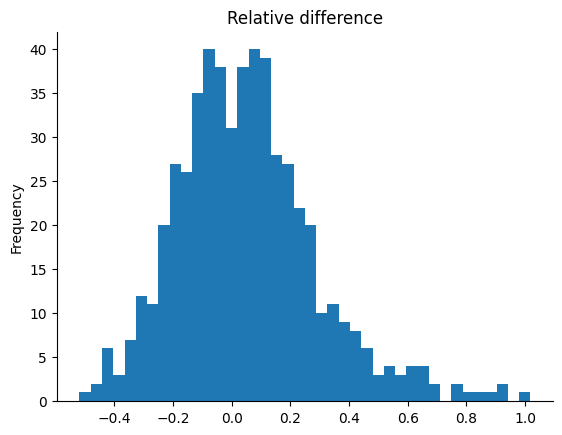

In [ ]:
from matplotlib import pyplot as plt
dfr['rel'].plot(kind='hist', bins=40, title='Relative difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

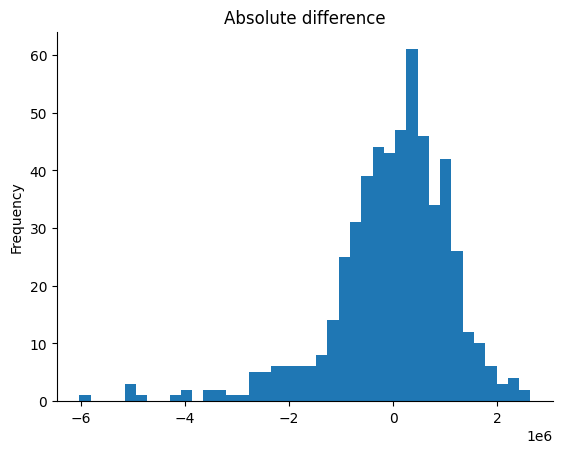

In [ ]:
from matplotlib import pyplot as plt
dfr['diff'].plot(kind='hist', bins=40, title='Absolute difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Home equity line

https://www.kaggle.com/datasets/averkiyoliabev/home-equity-line-of-creditheloc

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("heloc_dataset_v1 (1).csv")

In [ ]:
df['RiskPerformance'] = df['RiskPerformance'].map({'Good': 1, 'Bad': 0})
df['RiskPerformance'] = df.pop('RiskPerformance')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [ ]:
x = df.to_numpy()

### Common grammar

In [ ]:
out =  pdiv(pdiv(x[:, 14], psqrt(plog((x[:, 21] + pdiv(x[:, 5], pdiv(x[:, 8], (pdiv(x[:, 9], pdiv(x[:, 14], pdiv(x[:, 1], x[:, 17]))) * -0.01))))))), pdiv(x[:, 21], (pdiv(x[:, 5], pdiv(((-0.01 - pdiv(pdiv(-1.0, 1.0), plog((x[:, 21] + pdiv(x[:, 5], pdiv(x[:, 14], plog((x[:, 21] + pdiv(x[:, 5], pdiv(x[:, 14], pdiv(1.0, 0.001))))))))))) - x[:, 14]), (((x[:, 2] - 1.0) - pdiv(pdiv(psqrt(((x[:, 21] * x[:, 7]) + pdiv(x[:, 11], plog(-0.01)))), pdiv((x[:, 2] * x[:, 21]), x[:, 2])), (0.01 + psqrt(plog(x[:, 14]))))) + x[:, 22]))) * pdiv(x[:, 21], 1.0))))

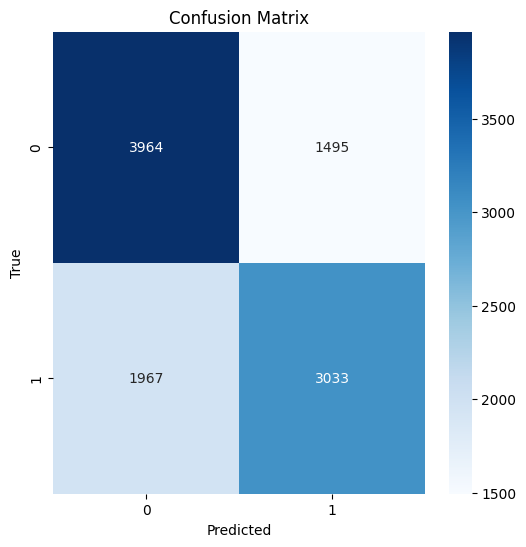

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      5459
           1       0.67      0.61      0.64      5000

    accuracy                           0.67     10459
   macro avg       0.67      0.67      0.67     10459
weighted avg       0.67      0.67      0.67     10459



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Neural-like grammar

In [ ]:
out =  ge_hyperbolic_tangent(np.exp(plog(np.sin(96.35)))-psqrt(pdiv(x[:, 17],plog(np.exp(pdiv(x[:, 4],psqrt(x[:, 19])+x[:, 5]*(x[:, 10])))-np.tanh(plog(plog(psqrt(x[:, 7])))*plog(psqrt(x[:, 16])))-np.exp((pdiv(plog(np.sin(82.64)),x[:, 9])))))))*19.13

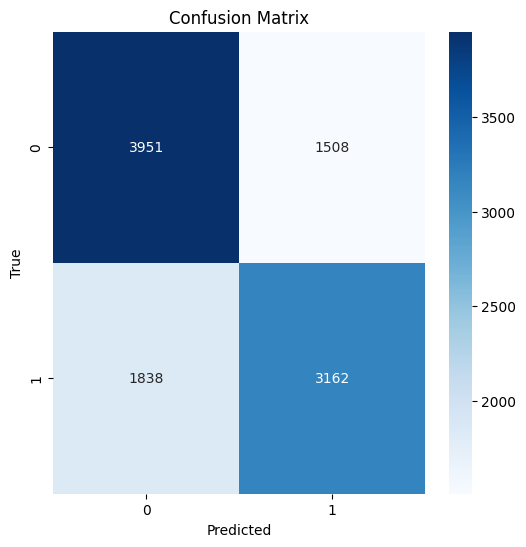

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      5459
           1       0.68      0.63      0.65      5000

    accuracy                           0.68     10459
   macro avg       0.68      0.68      0.68     10459
weighted avg       0.68      0.68      0.68     10459



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

## Diabetes Dataset

https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("diabetes.csv")

In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [4]:
x = df.to_numpy()

### Common grammar

#### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         18
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [15]:
out = (pdiv((x[:, 1] + pdiv(-1.0, 0.01)), x[:, 1]) - plog((pdiv(-0.01, pdiv(pdiv(x[:, 5], psqrt(plog((x[:, 6] - psqrt(1.0))))), x[:, 1])) - plog((pdiv(-0.01, pdiv(pdiv(x[:, 5], psqrt(plog((x[:, 6] - plog(x[:, 1]))))), pdiv(-1.0, 0.001))) + -0.1)))))

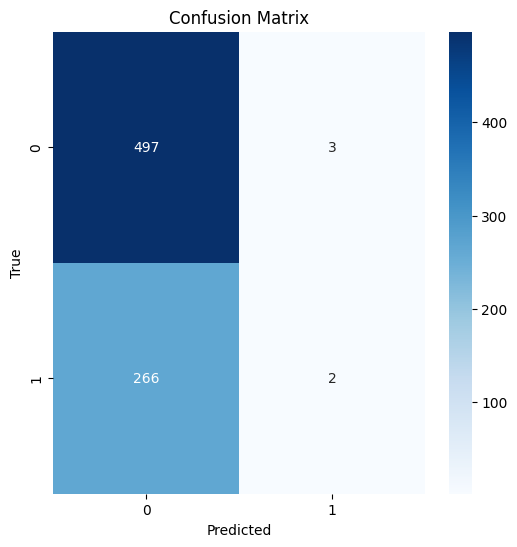

              precision    recall  f1-score   support

           0       0.65      0.99      0.79       500
           1       0.40      0.01      0.01       268

    accuracy                           0.65       768
   macro avg       0.53      0.50      0.40       768
weighted avg       0.56      0.65      0.52       768



In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 2

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [17]:
out = pdiv(((pdiv((1.0 - psqrt(0.001)), psqrt((-1.0 * x[:, 1]))) + -0.1) + psqrt(plog(pdiv(-0.01, (x[:, 5] - -0.01))))), pdiv(((pdiv(-0.001, x[:, 3]) * ((pdiv(pdiv(x[:, 0], 0.01), ((psqrt(psqrt(plog(pdiv(-0.01, (x[:, 5] - 0.01))))) + -0.001) * plog(1.0))) + pdiv(x[:, 0], psqrt(1.0))) - psqrt(0.001))) - ((-1.0 * x[:, 1]) + -0.1)), -0.1))

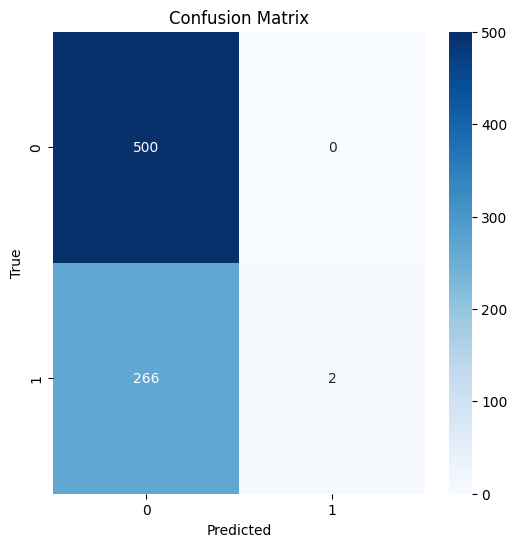

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       500
           1       1.00      0.01      0.01       268

    accuracy                           0.65       768
   macro avg       0.83      0.50      0.40       768
weighted avg       0.77      0.65      0.52       768



In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 3

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [19]:
out = ((x[:, 1] * plog(0.01)) - psqrt(plog(psqrt(psqrt(pdiv((plog(x[:, 1]) * ((plog(psqrt(-0.1)) - pdiv(psqrt(plog(plog(x[:, 1]))), plog(((plog(plog(x[:, 7])) * x[:, 0]) * x[:, 0])))) * x[:, 1])), plog((0.1 - (psqrt(plog(psqrt(psqrt(pdiv(plog(1.0), ((plog(-0.01) - (x[:, 1] + pdiv(0.01, -0.1))) * x[:, 5])))))) - x[:, 6])))))))))

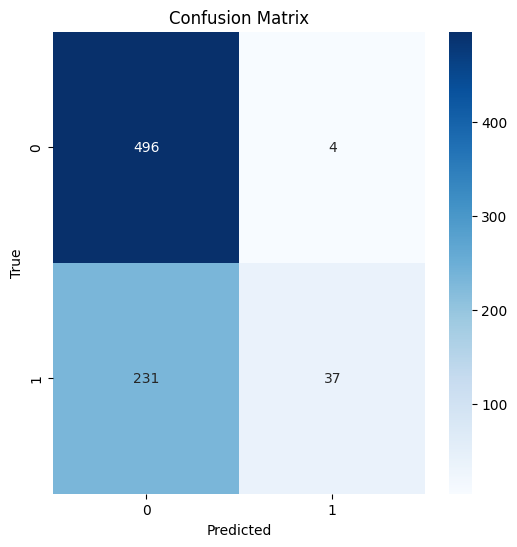

              precision    recall  f1-score   support

           0       0.68      0.99      0.81       500
           1       0.90      0.14      0.24       268

    accuracy                           0.69       768
   macro avg       0.79      0.57      0.52       768
weighted avg       0.76      0.69      0.61       768



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Neural-like grammar

#### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.70
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [ ]:
out =  ge_softplus(plog(x[:, 3])+x[:, 1]-np.exp(psqrt(26.26))-plog(pdiv(x[:, 2],plog(np.exp(pdiv(02.99,np.sin((x[:, 2]))*x[:, 7]*np.exp(x[:, 5])*x[:, 2]))-np.tanh(23.77))))*np.tanh(psqrt(plog(psqrt(53.75))))+(plog(psqrt(54.11))))*np.exp(psqrt(pdiv((52.27),pdiv(psqrt(53.11),03.32))+(47.32)))

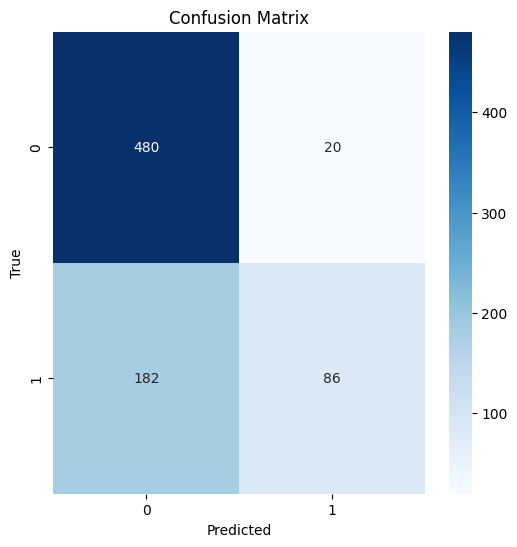

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       500
           1       0.81      0.32      0.46       268

    accuracy                           0.74       768
   macro avg       0.77      0.64      0.64       768
weighted avg       0.76      0.74      0.70       768



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 2

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.70
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1200
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         18
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```

In [68]:
out =  ge_relu(psqrt(x[:, 7]*95.91+x[:, 6]*94.55+x[:, 1]*(x[:, 5]))-(88.24))*30.16-psqrt((50.83)-plog((pdiv(31.50*65.82,06.18))))-30.31

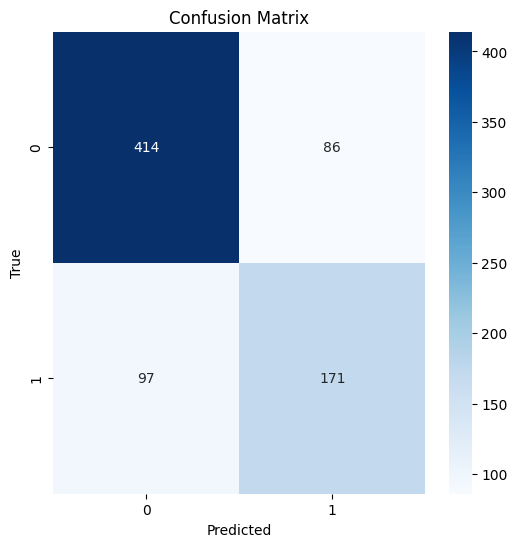

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       500
           1       0.67      0.64      0.65       268

    accuracy                           0.76       768
   macro avg       0.74      0.73      0.74       768
weighted avg       0.76      0.76      0.76       768



In [69]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 3

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.70
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1200
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [70]:
out = ge_relu(np.tanh(x[:, 1])-94.55-plog(71.84)*np.exp(psqrt(11.82))+x[:, 1]+pdiv((71.84),(psqrt(psqrt(03.90)+psqrt(pdiv(79.55,psqrt(45.39)))-x[:, 1])))+pdiv((71.64),(plog(psqrt(31.98))))+x[:, 5]-psqrt(19.71)+np.sin((psqrt(psqrt(34.98))))*x[:, 5]+np.sin(plog(pdiv(psqrt(pdiv(59.55,psqrt(93.49))),x[:, 1]))-pdiv((((plog(pdiv(psqrt(x[:, 2]),x[:, 1]))))),66.66)+np.exp(17.18)-np.sin(psqrt(psqrt(11.85))+x[:, 0])*(pdiv(np.exp(plog(pdiv(x[:, 2],psqrt((psqrt(np.exp(plog(np.sin(psqrt(x[:, 6])))))))))),psqrt(38.92)-plog(71.84)))+np.exp(psqrt(14.99))+psqrt(pdiv(psqrt(x[:, 1]),pdiv(((psqrt(psqrt(34.68)))),x[:, 5])+np.sin(plog(pdiv(psqrt(pdiv(59.55,psqrt(93.49))),x[:, 1]))*(np.sin((psqrt(psqrt(03.79))))*x[:, 6]))))))*93.87

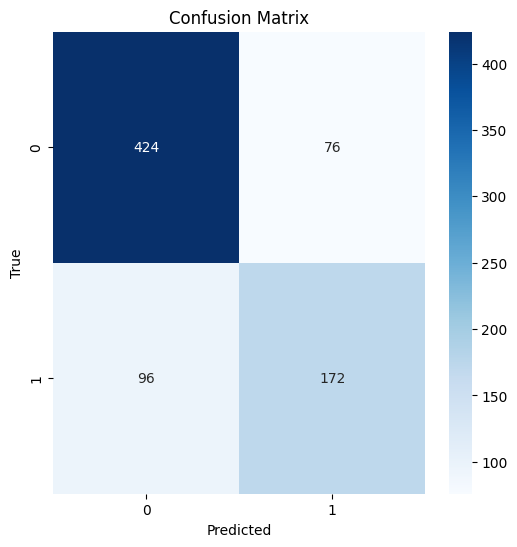

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       500
           1       0.69      0.64      0.67       268

    accuracy                           0.78       768
   macro avg       0.75      0.74      0.75       768
weighted avg       0.77      0.78      0.77       768



In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 4

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            2000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False

```

In [5]:
out =  ge_hyperbolic_tangent(np.sin(plog(53.27-plog(x[:, 5])*x[:, 1]+plog(plog(np.exp((plog(np.tanh(77.92))+(60.08)+np.exp(plog(x[:, 4]))+psqrt(psqrt(x[:, 2]))-61.41-psqrt(plog(x[:, 1])+61.81)-72.21)-72.71-np.tanh(psqrt(psqrt(np.exp(x[:, 3])))))))-psqrt(plog(np.tanh(x[:, 2]*47.16))+71.91-58.40-x[:, 5])*28.05)))*plog(np.sin(np.tanh(plog((72.80)))-np.sin(26.99)+psqrt(86.01)*np.tanh(75.08)+np.exp(psqrt(pdiv(np.sin(58.59),np.exp((np.tanh(np.sin(np.sin(96.14)*40.22)))))))+77.27*np.exp(np.tanh(psqrt(((np.sin((np.sin(plog(((psqrt(94.76)))))))))+77.23*81.31*psqrt((np.tanh(99.67)))+82.80))+psqrt(np.exp(psqrt(05.09))*plog(pdiv(np.exp(46.14),77.62)+26.99)))))

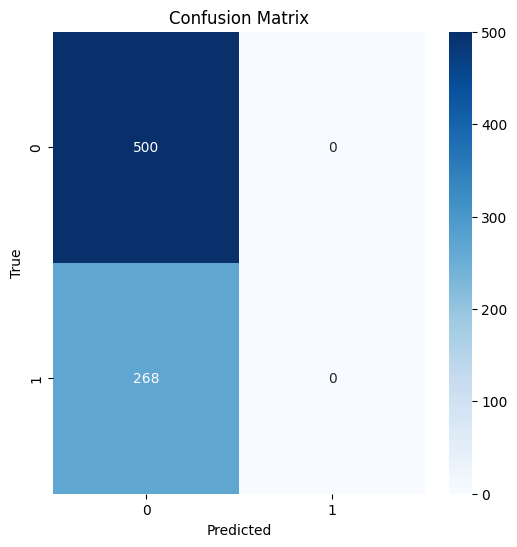

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       500
           1       0.00      0.00      0.00       268

    accuracy                           0.65       768
   macro avg       0.33      0.50      0.39       768
weighted avg       0.42      0.65      0.51       768



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 5

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            2000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [7]:
out =  ge_relu(np.tanh(x[:, 1]-(psqrt(plog(12.39)))*78.94)*(pdiv(np.exp(x[:, 5]),x[:, 1]-(psqrt(plog(19.06)))*x[:, 5]+(psqrt(psqrt(pdiv(psqrt(40.47),x[:, 5]))))*psqrt(np.exp((np.sin(20.39))-79.31*np.sin(psqrt(x[:, 5]))))*psqrt(np.sin((plog((x[:, 1])-19.14)-71.67*x[:, 6]))+np.exp(np.sin(x[:, 1]-x[:, 1])))))-(psqrt(psqrt(plog(x[:, 2])))))*np.exp(01.88)

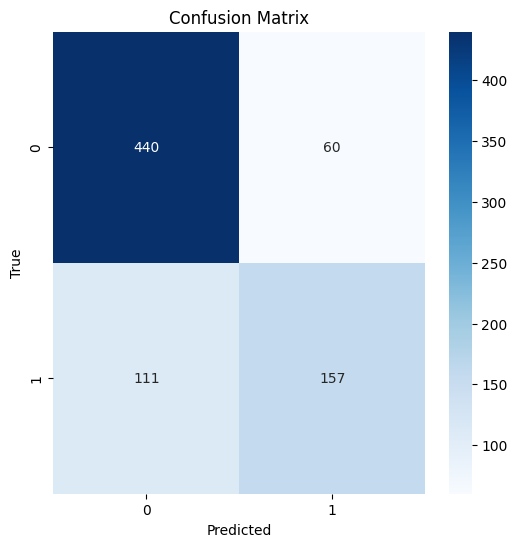

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       500
           1       0.72      0.59      0.65       268

    accuracy                           0.78       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.78      0.77       768



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 6

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            100
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g2.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [9]:
out =  np.sin((pdiv(x[:, 1],psqrt(509.546)))+pdiv(psqrt((x[:, 5])*151.934),x[:, 1]))

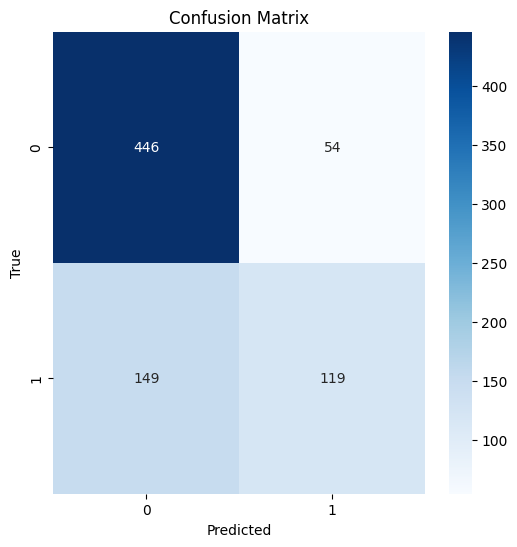

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       500
           1       0.69      0.44      0.54       268

    accuracy                           0.74       768
   macro avg       0.72      0.67      0.68       768
weighted avg       0.73      0.74      0.72       768



In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 7

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g2.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [11]:
out =  pdiv(pdiv(plog(ge_relu(x[:, 5]-psqrt(892.374))),plog(945.146)*np.sin(psqrt((x[:, 1]))+ge_softplus((plog(ge_hyperbolic_tangent(ge_softplus(ge_relu(ge_softplus(ge_hyperbolic_tangent(x[:, 3]))))+x[:, 3])+psqrt(plog(ge_softplus(186.459))+(x[:, 1])-ge_softplus((x[:, 1]))-ge_softplus(ge_sigmoid(np.tanh(plog(x[:, 1]))))))*ge_softplus(pdiv(np.tanh(ge_relu(plog(psqrt(x[:, 7]-psqrt(199.818))))*ge_sigmoid(x[:, 3])),ge_relu(np.exp(np.sin(psqrt((x[:, 1]))+np.tanh(ge_relu(np.tanh(psqrt(025.599)-ge_softplus(plog(929.309)))))))*ge_softplus((np.tanh(plog(ge_relu(x[:, 5]-psqrt(977.094))))))))))))),np.sin(np.exp(np.sin(psqrt((x[:, 1]))+pdiv(np.exp(np.tanh(psqrt(025.718)-ge_relu(ge_sigmoid(x[:, 3])))),ge_relu(x[:, 1]*psqrt((x[:, 6]))+pdiv(ge_relu(np.tanh(psqrt(011.863)-x[:, 2])),596.975)))))))

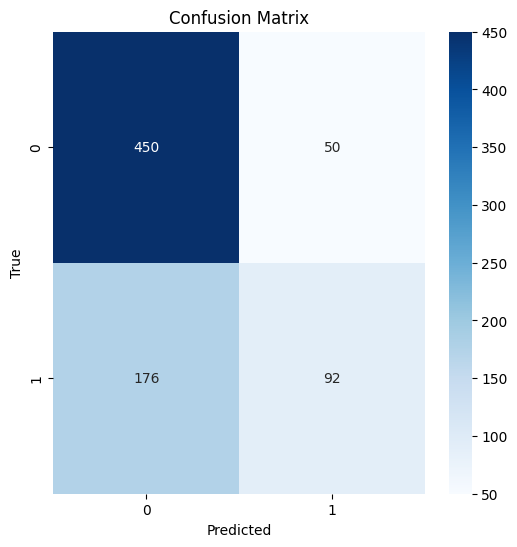

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       500
           1       0.65      0.34      0.45       268

    accuracy                           0.71       768
   macro avg       0.68      0.62      0.62       768
weighted avg       0.69      0.71      0.68       768



In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 8

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          diabetes/train.txt
DATASET_TEST:           diabetes/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g2.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         18
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [13]:
out =  x[:, 5]-165.604+x[:, 1]+pdiv(np.sin(np.tanh(144.752-x[:, 1]+plog(pdiv(np.tanh(x[:, 1])+np.sin(ge_relu(132.617))-ge_relu(psqrt((247.927))),np.exp(497.445)+ge_hyperbolic_tangent(ge_softplus(x[:, 5])))))),np.tanh(np.sin(np.sin(ge_softplus((x[:, 3]))))))

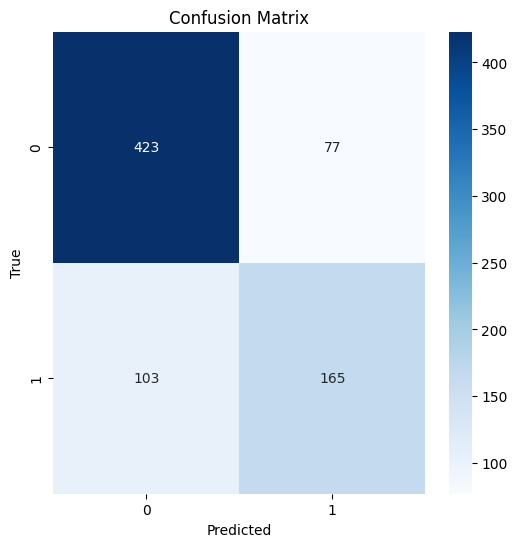

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       500
           1       0.68      0.62      0.65       268

    accuracy                           0.77       768
   macro avg       0.74      0.73      0.74       768
weighted avg       0.76      0.77      0.76       768



In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

## Churn dataset

https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

In [60]:
import pandas as pd
import numpy as np
dfa = pd.read_csv("customer_churn_dataset-testing-master.csv")
dfb = pd.read_csv("customer_churn_dataset-training-master.csv")

dfb["Churn"] = dfb["Churn"].fillna(0).astype(int)

In [61]:
df = pd.concat([dfa,dfb])
df = pd.get_dummies(df, columns=['Gender','Subscription Type', 'Contract Length'])
df.pop('CustomerID')
df['Churn'] = df.pop('Churn')
dummies_columns = [col for col in df.columns if col.startswith('Gender') or col.startswith('Subscription Type') or col.startswith('Contract Length')]
df[dummies_columns] = df[dummies_columns].astype(int)

In [62]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [63]:
x = df.to_numpy()

### Common grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          churn/train.txt
DATASET_TEST:           churn/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            100
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [6]:
out = ((x[:, 3] - x[:, 8]) - psqrt(pdiv(pdiv(x[:, 3], (x[:, 13] * pdiv(pdiv(x[:, 6], -1.0), 0.001))), psqrt(-0.01))))

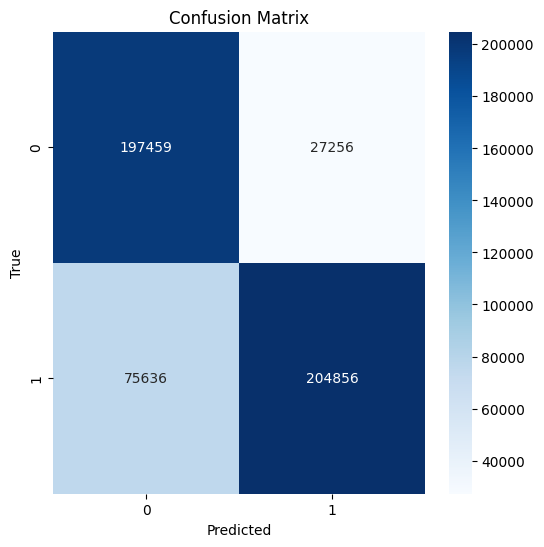

              precision    recall  f1-score   support

           0       0.72      0.88      0.79    224715
           1       0.88      0.73      0.80    280492

    accuracy                           0.80    505207
   macro avg       0.80      0.80      0.80    505207
weighted avg       0.81      0.80      0.80    505207



In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Neural-like grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          churn/train.txt
DATASET_TEST:           churn/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            100
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False


```

In [6]:
out = ge_relu(x[:, 3]-plog(x[:, 0]-x[:, 9]-plog(np.tanh(plog(np.tanh(np.sin((psqrt(psqrt(x[:, 9]))+67.53)))))-(np.tanh(x[:, 7])))))*np.exp(np.tanh(np.tanh((96.50)))) + ge_hyperbolic_tangent(x[:, 13])*(91.07)-psqrt(pdiv(pdiv(76.85,psqrt(12.27)),47.70-np.tanh(np.exp(14.65)-45.01)))

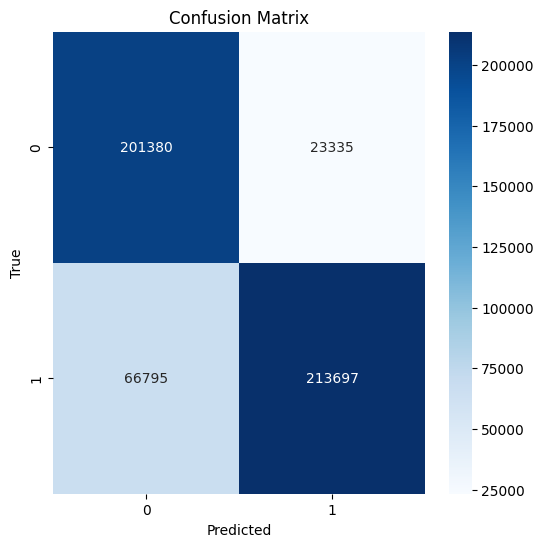

              precision    recall  f1-score   support

           0       0.75      0.90      0.82    224715
           1       0.90      0.76      0.83    280492

    accuracy                           0.82    505207
   macro avg       0.83      0.83      0.82    505207
weighted avg       0.83      0.82      0.82    505207



In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = df.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

## Loan dataset

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("loan_data.csv")

In [3]:
df = pd.get_dummies(df, columns=['person_gender', 'person_education','person_home_ownership','loan_intent'], dtype=int)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})
df['loan_status'] = df.pop('loan_status')

In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
class_column = df.columns[-1]
class_counts = df[class_column].value_counts()
min_count = class_counts.min()
balanced_df = df.groupby(class_column).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df[class_column], random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)


<ipython-input-128-55698f770f5f>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(class_column).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [4]:
dfx = df
x = dfx.to_numpy()

### Common grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          loan/train.txt
DATASET_TEST:           loan/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```

In [38]:
out = ((x[:, 5] * 0.1) - (pdiv(psqrt(pdiv(pdiv(pdiv(pdiv((-0.001 * -0.001), 0.1), (x[:, 4] * -0.1)), pdiv(pdiv(0.001, 1.0), psqrt(1.0))), pdiv(pdiv((x[:, 13] - ((x[:, 8] * ((x[:, 16] * (x[:, 0] * 0.1)) + -0.1)) + -1.0)), (pdiv(((x[:, 19] - (x[:, 22] * -0.01)) - ((((x[:, 16] * (x[:, 0] * 0.1)) + -0.1) - x[:, 14]) + (pdiv(x[:, 0], 0.001) - pdiv(psqrt(pdiv(x[:, 8], ((-0.001 * pdiv(1.0, 0.01)) + pdiv(1.0, -0.1)))), (x[:, 22] + x[:, 6]))))), 0.01) + (pdiv(x[:, 4], (x[:, 0] * 0.1)) * -0.1))), pdiv(x[:, 8], ((x[:, 6] * 0.001) - pdiv(psqrt(pdiv(x[:, 8], ((-0.001 * pdiv(1.0, 0.01)) + pdiv(1.0, -0.001)))), (0.001 + psqrt(x[:, 10])))))))), 0.1) - plog(pdiv(1.0, plog(((0.01 - x[:, 16]) + 0.01))))))

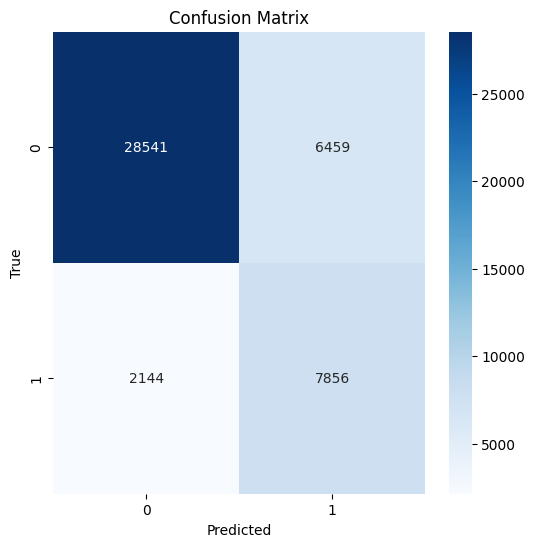

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     35000
           1       0.55      0.79      0.65     10000

    accuracy                           0.81     45000
   macro avg       0.74      0.80      0.76     45000
weighted avg       0.85      0.81      0.82     45000



In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = dfx.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Neural-like grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          loan/train.txt
DATASET_TEST:           loan/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            500
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [7]:
out = ge_hyperbolic_tangent((x[:, 5]-plog(x[:, 8]))*np.exp((psqrt(x[:, 4])))-np.sin(plog(np.sin(np.tanh(psqrt(pdiv((x[:, 16]),58.54)))+pdiv(pdiv(x[:, 8]-np.sin(x[:, 18]+x[:, 8]),plog(np.sin(x[:, 22]))),np.exp(np.tanh((x[:, 13]+np.tanh((np.sin((91.25))))*x[:, 11])+pdiv((x[:, 21])-(pdiv(plog(77.75)-x[:, 21]-x[:, 21],x[:, 24]))-07.07,np.tanh(np.sin(pdiv(np.tanh(x[:, 6]),x[:, 3]))+np.exp(x[:, 18])))*x[:, 3]))))))-np.exp(np.sin(plog((x[:, 0]-np.sin(x[:, 14]))+pdiv(np.sin(x[:, 24])-np.tanh(pdiv(psqrt(64.82)-np.tanh(x[:, 12]),x[:, 3]))*np.exp(59.42),np.exp(np.sin(x[:, 18])*np.sin(np.exp((x[:, 22])))))-x[:, 23]+plog(np.exp(plog(psqrt(np.tanh(pdiv(psqrt(56.82)-np.tanh(20.71),x[:, 17]))*x[:, 23])))-71.79)))))*np.exp(np.tanh(psqrt(pdiv(np.exp(np.tanh((np.tanh(91.25)))*np.exp((plog((74.88))))),psqrt((np.exp(np.tanh(np.tanh(plog(64.39)))))))))*np.exp(pdiv((np.exp(np.tanh(np.sin(plog(np.exp(plog(np.sin(np.exp(74.34))))))))),np.exp(np.tanh((np.tanh(np.sin(44.00))))))))

In [142]:
# out = ge_relu(np.exp(pdiv(psqrt(x[:, 5]),x[:, 16]))-x[:, 25]*x[:, 25]-pdiv(psqrt(x[:, 8]),plog((np.sin(plog(np.sin(x[:, 5])))+np.tanh(np.sin(np.tanh(np.sin(plog(x[:, 19])))))))))*psqrt(np.exp(20.84)*((psqrt(pdiv(pdiv(11.34,np.exp((25.71))),psqrt(((48.63)))))))) + ge_softplus(x[:, 4])*plog(59.89)-np.sin((91.38))+pdiv(pdiv(np.tanh(plog(np.tanh(np.sin(53.19))))-71.22,36.90)*36.81*01.94+pdiv(psqrt(np.tanh(59.72)),42.08),(np.tanh((psqrt(pdiv(pdiv(pdiv(plog(np.tanh(plog(np.tanh(psqrt(49.21))))),np.sin(81.68))*12.85+(np.sin(33.96))+pdiv(41.60,plog(plog(71.22))*36.90)-36.81*01.94,pdiv(psqrt(np.tanh(59.72)),42.08)),(np.tanh((psqrt(pdiv(pdiv(35.94+16.85*61.94+pdiv(psqrt(np.tanh(58.89)),np.sin(psqrt(09.95))),(np.sin(31.48))),28.25)))))))))))+psqrt(59.76)

In [5]:
# out = pdiv(pdiv((ge_relu(np.tanh(ge_relu(ge_relu(np.tanh(x[:, 10])))))),596.044),psqrt(x[:, 10]))-x[:, 8]-x[:, 16]*(x[:, 21])

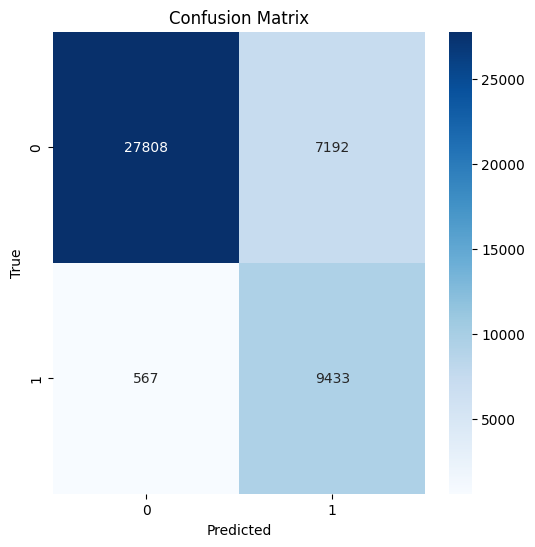

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     35000
           1       0.57      0.94      0.71     10000

    accuracy                           0.83     45000
   macro avg       0.77      0.87      0.79     45000
weighted avg       0.89      0.83      0.84     45000



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = dfx.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

## Kickstarter DS

https://www.kaggle.com/datasets/codename007/funding-successful-projects

### Installing additional dependencies


It is highly advised to run the following code using CUDA accelerated processing on GPU

In [ ]:
!pip install sentence-transformers

### Data preprocessing

Code was prepared in such a manner to allow reuse of already generated data. Be aware that embedding takes a signifficant amount of time and shall not be repeated, as that may be a waste of energy

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
df = pd.read_csv("train.csv")

In [ ]:
# Transforming the initial dataset and cleaning
df['disable_communication'] = df['disable_communication'].astype(int)
df = pd.get_dummies(df, columns=['country', 'currency'])
dummies_columns = [col for col in df.columns if col.startswith('country') or col.startswith('currency')]
df[dummies_columns] = df[dummies_columns].astype(int)
df['concat'] = "Project name is " + df['name'] + "; It was described as follows: " + df['desc'] + " author marked it with kwywords: " +df['keywords']
df = df.drop(columns=['project_id','name','desc','keywords'])

In [ ]:
# Embedding; results are stored in embeddings.csv in such a way that row i from initial df is encoded in i'th row of embeddings, each columns is another dimmension
model = SentenceTransformer("all-MiniLM-L6-v2")
df['concat'] = df['concat'].fillna('Brak danych')
embeddings = model.encode(df['concat'].tolist())
embeddings_df = pd.DataFrame(embeddings, columns=[f"embed_{i}" for i in range(embeddings.shape[1])])
embeddings_df.to_csv("embeddings.csv", index=False)

In [ ]:
# Loading ready embeddings and concatenating with existing initial df to make a single dataset
# Results are stored to final dataset csv file that may be later used
embeddings_df = pd.read_csv('embeddings.csv')
df = pd.concat([df, embeddings_df], axis=1)
df['final_status'] = df.pop('final_status')
df = df.drop(columns=['concat'])
df.to_csv("dataset.csv", index=False)

In [7]:
# If you have your dataset already preprocessed, there is no need to execute steps above, just load the data
import pandas as pd
import numpy as np
df = pd.read_csv("dataset.csv")

In [ ]:
# Generating the files for PonyGE2; if you are not running the evolution, you may skip this part
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
class_column = df.columns[-1]
class_counts = df[class_column].value_counts()
min_count = class_counts.min()
balanced_df = df.groupby(class_column).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df[class_column], random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

In [8]:
# Preparing the data to be used during the validation
dfx = df
x = dfx.to_numpy()

### Common grammar

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          kickstarter/balanced/train.txt
DATASET_TEST:           kickstarter/balanced/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            150
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g1.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [9]:
out = pdiv(0.1, (x[:, 6] - (x[:, 328] + pdiv(psqrt(x[:, 0]), psqrt(plog(psqrt(pdiv(pdiv(pdiv(pdiv((0.01 + plog((x[:, 99] - x[:, 44]))), pdiv(1.0, pdiv(pdiv(0.01, -1.0), ((x[:, 99] - x[:, 0]) * (x[:, 0] * (plog((x[:, 119] * (0.001 * plog(-1.0)))) - x[:, 64])))))), pdiv((plog(0.001) * -0.001), -1.0)), (0.001 * -0.01)), psqrt(x[:, 197])))))))))

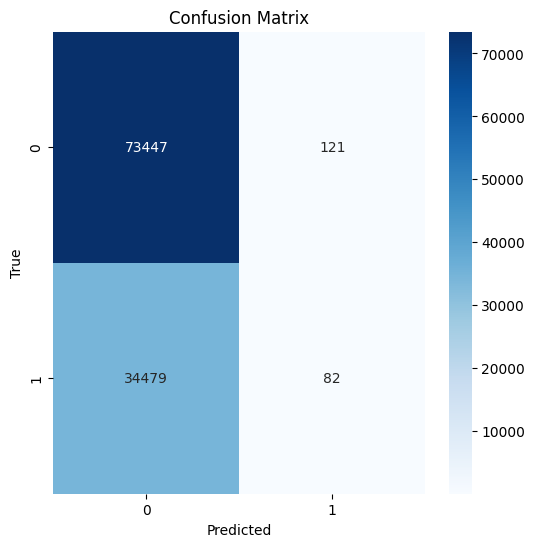

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     73568
           1       0.40      0.00      0.00     34561

    accuracy                           0.68    108129
   macro avg       0.54      0.50      0.41    108129
weighted avg       0.59      0.68      0.55    108129



In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = dfx.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

### Neural-like grammar

#### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          kickstarter/balanced/train.txt
DATASET_TEST:           kickstarter/balanced/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            150
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

In [11]:
out = ge_relu(x[:, 6])*np.tanh((plog(34.80)))-20.29 + ge_sigmoid(ge_hyperbolic_tangent(x[:, 53])*pdiv((81.96)-23.01,plog(pdiv(plog(75.83)-(38.26),22.07+plog(np.exp(63.23))-(psqrt((39.14)))))))*plog(21.65)

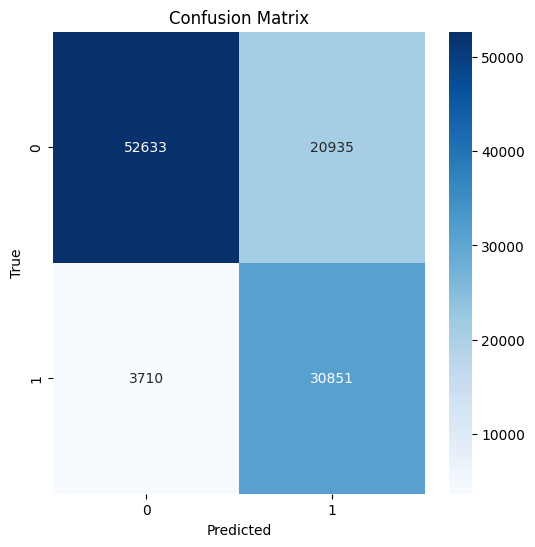

              precision    recall  f1-score   support

           0       0.93      0.72      0.81     73568
           1       0.60      0.89      0.71     34561

    accuracy                           0.77    108129
   macro avg       0.76      0.80      0.76    108129
weighted avg       0.83      0.77      0.78    108129



In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = dfx.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

#### Attempt 2



```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          kickstarter/balanced/train.txt
DATASET_TEST:           kickstarter/balanced/test.txt
DEBUG:                  False
ERROR_METRIC:           f1_score
GENERATIONS:            300
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         27
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.classification
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False



```



In [14]:
out = ge_relu(ge_relu(x[:, 6])*00.92 + ge_hyperbolic_tangent(np.tanh(np.sin(plog(49.40))))*53.57*plog(np.tanh(50.36*plog(94.66))) + ge_hyperbolic_tangent(x[:, 187])*(pdiv(49.34,plog(np.tanh(50.70*np.exp(74.67))))))*pdiv(plog(24.83),pdiv(54.98,np.sin(np.tanh(91.49))))

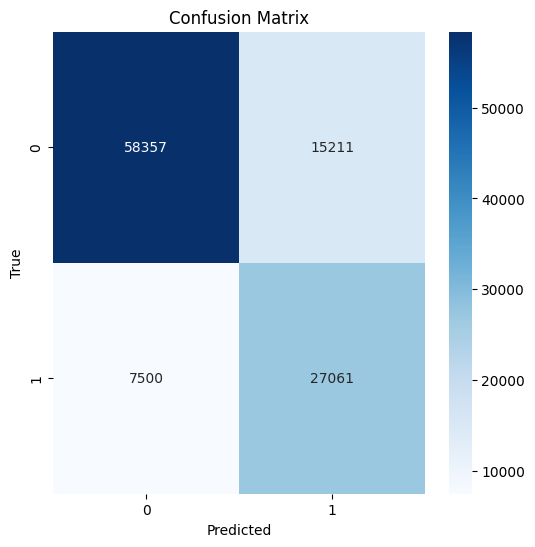

              precision    recall  f1-score   support

           0       0.89      0.79      0.84     73568
           1       0.64      0.78      0.70     34561

    accuracy                           0.79    108129
   macro avg       0.76      0.79      0.77    108129
weighted avg       0.81      0.79      0.79    108129



In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


true_classes = dfx.iloc[:, -1].values
predictions = out

true_classes = np.where(true_classes > 0.5, 1, 0)
predictions = np.where(predictions > 0.5, 1, 0)


cm = confusion_matrix(true_classes, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
from sklearn.metrics import classification_report
print(classification_report(true_classes, predictions))

# Improved prime number experiment

In [19]:
import pandas as pd
import sympy

PRIME_COUNT = 1000

def prime_pi_function(limit):
    primes = list(sympy.primerange(1, limit * 10))[:limit]
    pi_values = [sympy.primepi(p) for p in primes]
    return pd.DataFrame({'n': primes, 'pi(n)': pi_values})

df = prime_pi_function(PRIME_COUNT)
print(df)

        n pi(n)
0       2     1
1       3     2
2       5     3
3       7     4
4      11     5
..    ...   ...
995  7879   996
996  7883   997
997  7901   998
998  7907   999
999  7919  1000

[1000 rows x 2 columns]


In [6]:
import pandas as pd
import sympy

PRIME_COUNT = 1000


def prime_pi_function_extended(limit):
    max_n = sympy.prime(limit)
    values = list(range(1, max_n + 1))
    pi_values = [sympy.primepi(n) for n in values]
    return pd.DataFrame({'n': values, 'pi(n)': pi_values})

df = prime_pi_function_extended(PRIME_COUNT)
print(df)

         n pi(n)
0        1     0
1        2     1
2        3     2
3        4     2
4        5     3
...    ...   ...
7914  7915   999
7915  7916   999
7916  7917   999
7917  7918   999
7918  7919  1000

[7919 rows x 2 columns]


In [7]:
df['n'] = df['n'].astype(float)
df['pi(n)'] = df['pi(n)'].astype(float)

In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("train.txt", sep="\t", index=False)
test_df.to_csv("test.txt", sep="\t", index=False)

## Results

### Attempt 1

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          primes/train.txt
DATASET_TEST:           primes/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            600
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         25
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

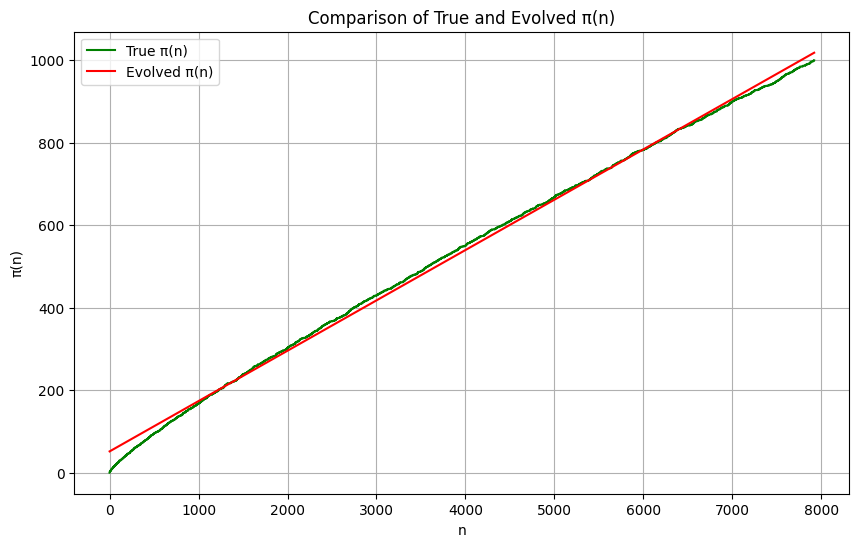

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = df.to_numpy()

out = ge_relu(x[:, 0])*((np.tanh(pdiv(np.exp(np.tanh(05.03)),21.55+np.sin(np.tanh(np.tanh(np.tanh(np.exp(psqrt((25.21)-np.tanh(56.59))+28.53+np.sin(np.tanh(plog(np.tanh(24.13)))))))))))))+50.78+psqrt(psqrt(plog(np.sin((76.19)))))
df['evolved_pi(n)'] = out

plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()

### Attempt 2

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          primes/train.txt
DATASET_TEST:           primes/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         30
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

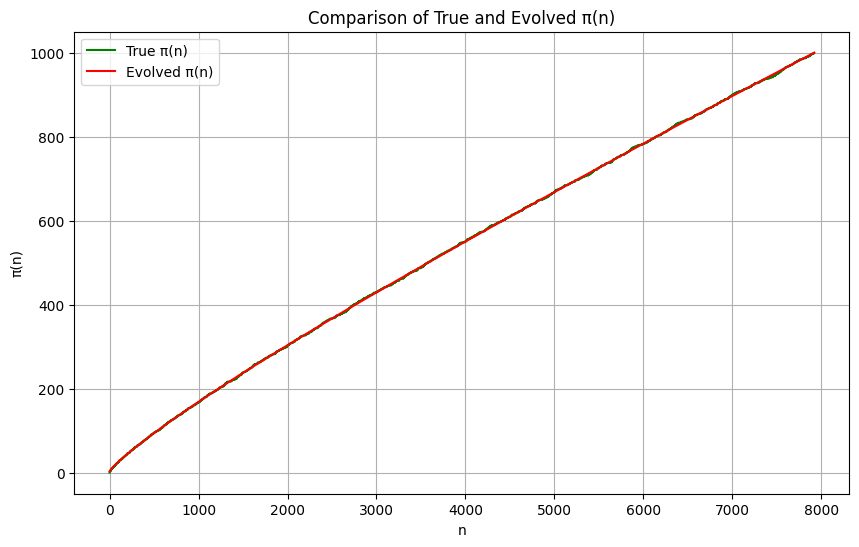

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = df.to_numpy()

out = ge_relu(pdiv(pdiv(x[:, 0],65.74),plog(x[:, 0])))*74.20 + ge_softplus(np.sin(plog(x[:, 0]+pdiv(x[:, 0],x[:, 0])+16.64+pdiv(86.44+99.99,psqrt(x[:, 0])))))*psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(np.exp(plog(pdiv(pdiv(45.08,00.63),56.02+plog(44.13)-np.tanh(np.sin(np.exp(pdiv((np.sin(01.78)),np.tanh(57.68))))))))))*plog(psqrt(psqrt(27.86)-np.exp(np.tanh(11.07-42.60)))*07.69)*plog(np.exp(plog(28.02))),psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(07.48))*np.exp(np.sin(55.36))+44.66-plog((07.63))*psqrt(01.72),(np.sin(63.22))),89.87)-(psqrt(pdiv(pdiv(np.tanh(np.sin(26.02)),69.60*plog(psqrt(47.57))),plog(04.50))))-73.75-pdiv(45.08,30.83))))),02.15*plog(np.exp(07.48))*np.exp(np.sin(55.37))+np.exp(07.59)-np.sin(np.exp(05.48))*np.exp(np.sin(55.37))+54.08-82.75*np.exp((np.sin(76.36)))*plog(psqrt(07.68)))-plog(np.exp(np.tanh(np.sin(02.79-16.66+27.81))))*np.tanh(47.58)-plog(28.61)+plog(np.tanh(pdiv(14.66,plog(psqrt(07.63))))))))
df['evolved_pi(n)'] = out

plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()

### Attempt 3

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          primes/train.txt
DATASET_TEST:           primes/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         27
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

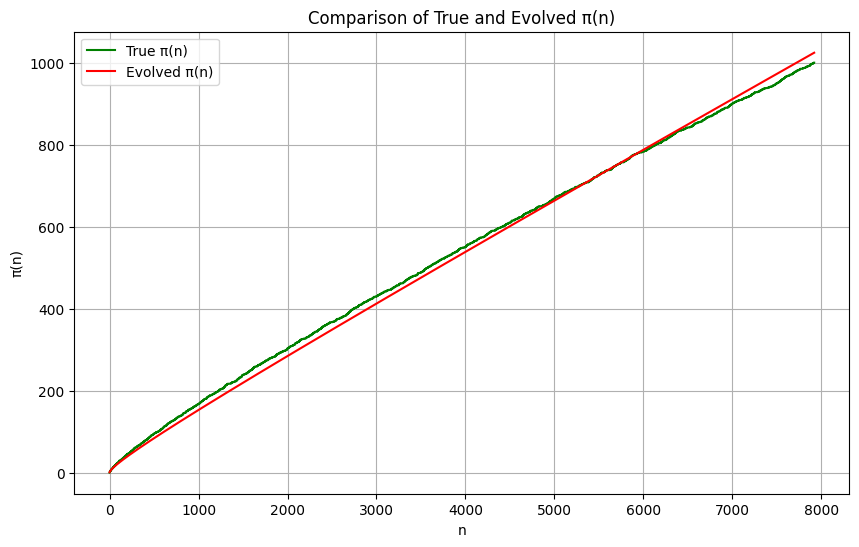

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = df.to_numpy()

out  =  ge_relu(x[:, 0]+psqrt(np.tanh(89.70)*99.98*x[:, 0]))*pdiv(np.exp(np.tanh(pdiv(plog(np.sin((np.sin(09.42)+92.54))),plog(np.exp(np.exp(14.93-94.46+np.tanh(np.sin(17.18)))))-np.tanh(86.00))-plog(pdiv(psqrt(74.16),np.sin(plog(np.exp(np.tanh(np.exp(84.04))))+pdiv(37.91-95.74+pdiv(np.tanh(np.sin(97.31+plog(02.89)*67.49+54.54*29.59)),np.tanh(88.17))*(46.04),94.42))*np.tanh(plog(np.exp(np.tanh((87.67+47.31*74.39*82.42)))))))*pdiv(np.exp(plog(np.exp(np.tanh(psqrt(33.81))))-pdiv(17.94,np.sin(78.37)+07.89)),np.sin(67.69+34.46))*plog(np.sin(82.15)-plog(32.59)*np.sin(((91.46)))))),plog(22.81))
df['evolved_pi(n)'] = out

plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()

### Attempt 4

```
CACHE:                  True
CODON_SIZE:             100000
CROSSOVER:              variable_onepoint
CROSSOVER_PROBABILITY:  0.75
DATASET_TRAIN:          primes/train.txt
DATASET_TEST:           primes/test.txt
DEBUG:                  False
ERROR_METRIC:           mse
GENERATIONS:            1000
MAX_GENOME_LENGTH:      600
GRAMMAR_FILE:           kickstarter/g3.bnf
INITIALISATION:         PI_grow
INVALID_SELECTION:      False
MAX_INIT_TREE_DEPTH:    10
MAX_TREE_DEPTH:         20
MUTATION:               int_flip_per_codon
POPULATION_SIZE:        1000
FITNESS_FUNCTION:       supervised_learning.regression
REPLACEMENT:            generational
SELECTION:              tournament
TOURNAMENT_SIZE:        2
VERBOSE: 				False
```

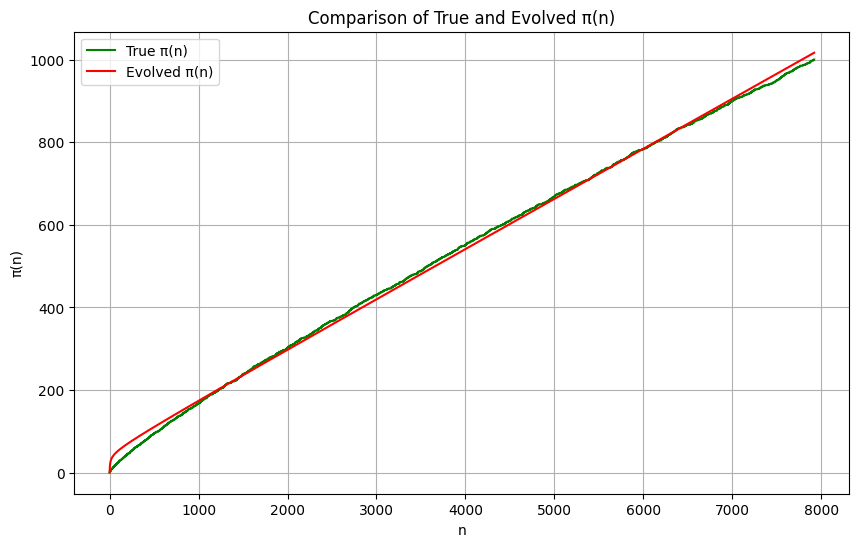

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = df.to_numpy()

out  =  ge_relu(38.50*x[:, 0]+psqrt(x[:, 0]))*pdiv(np.sin(pdiv(np.exp(74.13),96.40*psqrt(plog((21.73))))),psqrt(25.89*np.exp((np.tanh(34.61))))) + ge_hyperbolic_tangent(ge_softplus(np.exp(np.sin(x[:, 0])))*pdiv(51.33,psqrt((49.74*pdiv(plog(98.17)+np.tanh(psqrt(psqrt(99.93))),np.tanh(41.41)-pdiv(plog(np.sin(19.11)),(57.35)))))))*psqrt(99.03)-71.75+81.14-45.66+(np.tanh(71.83)) + ge_hyperbolic_tangent(14.59)*(np.tanh(09.89)) + ge_hyperbolic_tangent(63.08)*(07.57) + ge_relu(plog(plog(x[:, 0])))*33.89
df['evolved_pi(n)'] = out

plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()

## Extending the horizon

In [18]:
import pandas as pd
import sympy

PRIME_COUNT = 2000


def prime_pi_function_extended(limit):
    max_n = sympy.prime(limit)
    values = list(range(1, max_n + 1))
    pi_values = [sympy.primepi(n) for n in values]
    return pd.DataFrame({'n': values, 'pi(n)': pi_values})

df = prime_pi_function_extended(PRIME_COUNT)
print(df)

           n pi(n)
0          1     0
1          2     1
2          3     2
3          4     2
4          5     3
...      ...   ...
17384  17385  1998
17385  17386  1998
17386  17387  1999
17387  17388  1999
17388  17389  2000

[17389 rows x 2 columns]


In [20]:
df['n'] = df['n'].astype(float)
df['pi(n)'] = df['pi(n)'].astype(float)

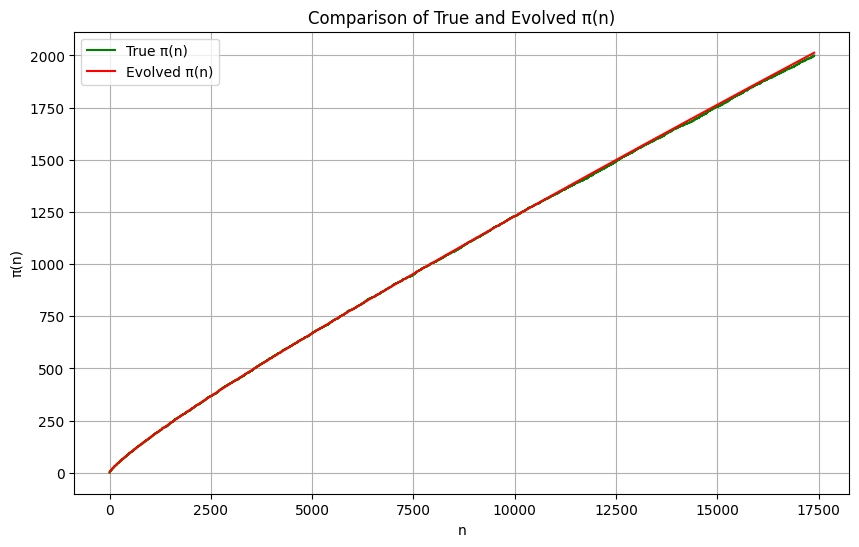

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x = df.to_numpy()

out = ge_relu(pdiv(pdiv(x[:, 0],65.74),plog(x[:, 0])))*74.20 + ge_softplus(np.sin(plog(x[:, 0]+pdiv(x[:, 0],x[:, 0])+16.64+pdiv(86.44+99.99,psqrt(x[:, 0])))))*psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(np.exp(plog(pdiv(pdiv(45.08,00.63),56.02+plog(44.13)-np.tanh(np.sin(np.exp(pdiv((np.sin(01.78)),np.tanh(57.68))))))))))*plog(psqrt(psqrt(27.86)-np.exp(np.tanh(11.07-42.60)))*07.69)*plog(np.exp(plog(28.02))),psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(07.48))*np.exp(np.sin(55.36))+44.66-plog((07.63))*psqrt(01.72),(np.sin(63.22))),89.87)-(psqrt(pdiv(pdiv(np.tanh(np.sin(26.02)),69.60*plog(psqrt(47.57))),plog(04.50))))-73.75-pdiv(45.08,30.83))))),02.15*plog(np.exp(07.48))*np.exp(np.sin(55.37))+np.exp(07.59)-np.sin(np.exp(05.48))*np.exp(np.sin(55.37))+54.08-82.75*np.exp((np.sin(76.36)))*plog(psqrt(07.68)))-plog(np.exp(np.tanh(np.sin(02.79-16.66+27.81))))*np.tanh(47.58)-plog(28.61)+plog(np.tanh(pdiv(14.66,plog(psqrt(07.63))))))))
df['evolved_pi(n)'] = out

plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()

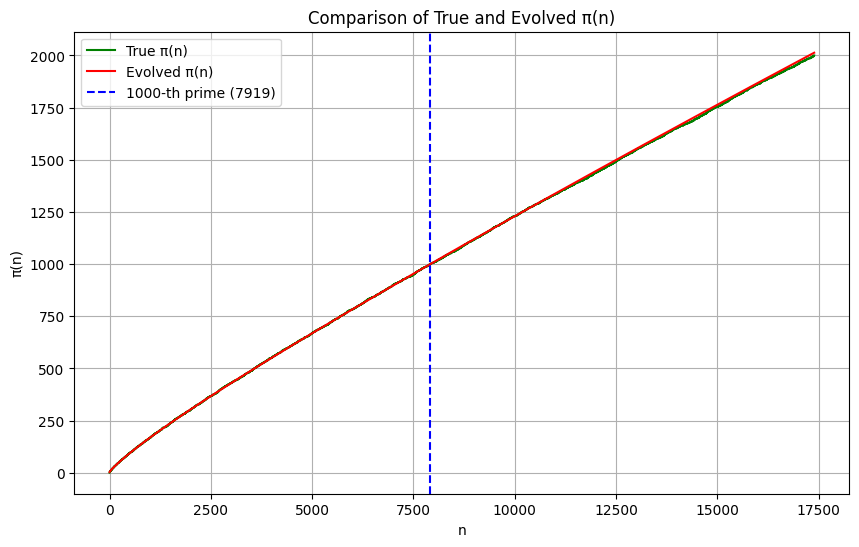

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy
x = df.to_numpy()

out = ge_relu(pdiv(pdiv(x[:, 0],65.74),plog(x[:, 0])))*74.20 + ge_softplus(np.sin(plog(x[:, 0]+pdiv(x[:, 0],x[:, 0])+16.64+pdiv(86.44+99.99,psqrt(x[:, 0])))))*psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(np.exp(plog(pdiv(pdiv(45.08,00.63),56.02+plog(44.13)-np.tanh(np.sin(np.exp(pdiv((np.sin(01.78)),np.tanh(57.68))))))))))*plog(psqrt(psqrt(27.86)-np.exp(np.tanh(11.07-42.60)))*07.69)*plog(np.exp(plog(28.02))),psqrt(plog(plog(np.tanh(np.sin(np.exp(16.62)))))-27.89+np.exp(np.tanh(pdiv(pdiv(01.15*np.sin(np.exp(07.48))*np.exp(np.sin(55.36))+44.66-plog((07.63))*psqrt(01.72),(np.sin(63.22))),89.87)-(psqrt(pdiv(pdiv(np.tanh(np.sin(26.02)),69.60*plog(psqrt(47.57))),plog(04.50))))-73.75-pdiv(45.08,30.83))))),02.15*plog(np.exp(07.48))*np.exp(np.sin(55.37))+np.exp(07.59)-np.sin(np.exp(05.48))*np.exp(np.sin(55.37))+54.08-82.75*np.exp((np.sin(76.36)))*plog(psqrt(07.68)))-plog(np.exp(np.tanh(np.sin(02.79-16.66+27.81))))*np.tanh(47.58)-plog(28.61)+plog(np.tanh(pdiv(14.66,plog(psqrt(07.63))))))))
df['evolved_pi(n)'] = out
df['evolved_pi(n)'] = out
prime_1000 = sympy.prime(1000)
plt.figure(figsize=(10, 6))
plt.step(df['n'], df['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df['n'], df['evolved_pi(n)'], color='red', label='Evolved π(n)')
plt.axvline(x=prime_1000, color='blue', linestyle='--', label=f'1000-th prime ({prime_1000})')
plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Comparison of True and Evolved π(n)')
plt.legend()
plt.grid()
plt.show()


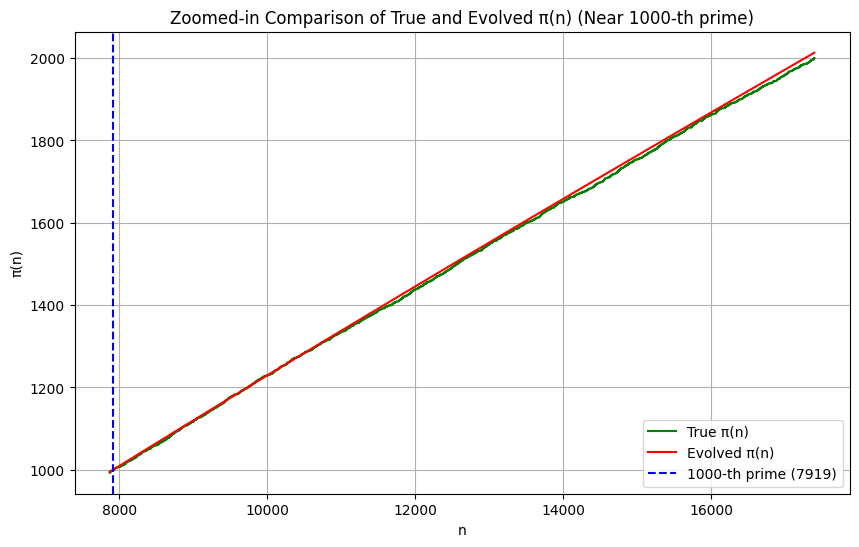

In [26]:
df_zoom = df[df['n'] > prime_1000 - 50]
plt.figure(figsize=(10, 6))
plt.step(df_zoom['n'], df_zoom['pi(n)'], where='post', color='green', label='True π(n)')
plt.plot(df_zoom['n'], df_zoom['evolved_pi(n)'], color='red', label='Evolved π(n)')
plt.axvline(x=prime_1000, color='blue', linestyle='--', label=f'1000-th prime ({prime_1000})')

plt.xlabel('n')
plt.ylabel('π(n)')
plt.title('Zoomed-in Comparison of True and Evolved π(n) (Near 1000-th prime)')

plt.legend()
plt.grid()
plt.show()